# Projet 5 - Segmentez des clients d'un site e-commerce

In [1]:
#pip install pandas numpy matplotlib seaborn missingno shap

In [2]:
import sys # Python v3.12.4
import pandas as pd # 2.2.3
import numpy as np # 2.1.2
import matplotlib.pyplot as plt
import seaborn as sns # 0.13.2
import missingno as msno # 0.5.2
import sqlite3

from scipy.stats import shapiro, kruskal, kstest


In [3]:
# Information sur l'environnement virtuel
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 2.0.2
Seaborn       : 0.13.2
missingno     : 0.5.2


In [4]:
# Paramètre d'affichage
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Fonction Utilitaires

In [ ]:
def start_eda(df):
    """
    Affiche des informations sur le contenu du dataset, son nombre de lignes et de colonnes
    ainsi qu'une vue statistique.
    """
    # Affiche les cinq premières lignes
    print(f"Visualisation des première lignes - head()")
    display(df.head())

    # Affiche les cinq dernières lignes
    print(f"Visualisation des dernière lignes - tail()")
    display(df.tail())

    # Affiche des informations générales sur le DataFrame
    print(f"\nInformations générales sur le DataFrame - info()")
    print(df.info())

    # Affiche le nombre de lignes et de colonnes
    print(f"Affichage de lignes et de colonnes")
    nb_lignes, nb_colonnes = df.shape
    type_colonnes = df.dtypes.value_counts()
    print(f"\nNombre de lignes : {nb_lignes}")
    print(f"Nombre de colonnes : {nb_colonnes}")
    print(f"Type des colonnes : \n{type_colonnes}")

    # Affiche les statistiques descriptives
    print(f"Affichage des données statistiques descriptives - describe()")
    display(df.describe())

def df_agg_clients(df):
    """
    Prend un DataFrame en entrée, le retourne en agrégé et
    groupé en fonction de l'identifiant client unique.
    """

    date_max = df["order_purchase_timestamp"].max()

    df["mean_shipping_time"] = (df["order_delivered_customer_date"]
                                - df["order_purchase_timestamp"])
    df["mean_delivery_delay"] = (df["order_delivered_customer_date"]
                                - df["order_estimated_delivery_date"])

    def get_mode(x):
        modes = x.mode()
        return modes[0] if not modes.empty else np.nan

    data_clients = df.groupby("customer_unique_id").agg(
        order_purchase_timestamp=("order_purchase_timestamp", "max"),
        order_delivered_customer_date=("order_delivered_customer_date", "max"),
        order_estimated_delivery_date=("order_estimated_delivery_date", "max"),
        time_since_first_order=("order_purchase_timestamp",
                                lambda x: (date_max - x.min()).days),
        time_since_last_order=("order_purchase_timestamp",
                            lambda x: (date_max - x.max()).days),
        mean_shipping_time=("mean_shipping_time",
                            lambda x: x.mean().days),
        mean_delivery_delay=("mean_delivery_delay",
                            lambda x: x.mean().days),
        customer_city=("customer_city", get_mode),
        customer_state=("customer_state", get_mode),
        nb_total_order=("order_id", "count"),
        nb_total_item=("product_id", "count"),
        total_price=("price", "sum"),
        mean_price=("price", "mean"),
        total_freight_value=("freight_value", "sum"),
        mean_freight_value=("freight_value", "mean"),
        payment_type=("payment_type", get_mode),
        mean_payment_installments=("payment_installments", "mean"),
        total_payment_value=("payment_value", "sum"),
        mean_payment_value=("payment_value", "mean"),
        mean_review_score=("review_score", "mean"),
        seller_city=("seller_city", get_mode),
        seller_state=("seller_state", get_mode),
        cat=("product_category_name_english", get_mode)
    )

    return data_clients

def df_agg_1(df): # Solution Alternative
    """
    Prend un DataFrame en entrée, le retourne en agrégé et
    groupé en fonction de l'identifiant client unique.
    """

    date_max = df["order_purchase_timestamp"].max()

    df["mean_shipping_time"] = (df["order_delivered_customer_date"]
                                - df["order_purchase_timestamp"])
    df["mean_delivery_delay"] = (df["order_delivered_customer_date"]
                                - df["order_estimated_delivery_date"])

    data_customers1 = df.groupby("customer_unique_id").agg(
        order_purchase_timestamp=("order_purchase_timestamp", "max"),
        order_delivered_customer_date=("order_delivered_customer_date", "max"),
        order_estimated_delivery_date=("order_estimated_delivery_date", "max"),
        time_since_first_order=("order_purchase_timestamp",
                                lambda x: (date_max - x.min()).days),
        time_since_last_order=("order_purchase_timestamp",
                            lambda x: (date_max - x.max()).days),
        mean_shipping_time=("mean_shipping_time", lambda x: x.mean().days),
        mean_delivery_delay=("mean_delivery_delay", lambda x: x.mean().days),
        customer_city=("customer_city", lambda x: x.mode()[0] if not x.mode().empty else np.nan),
        customer_state=("customer_state", lambda x: x.mode()[0] if not x.mode().empty else np.nan),
        nb_total_order=("order_id", "count"),
        nb_total_item=("product_id", "count"),
        total_price=("price", "sum"),
        mean_price=("price", "mean"),
        total_freight_value=("freight_value", "sum"),
        mean_freight_value=("freight_value", "mean"),
        payment_type=("payment_type", lambda x: x.mode()[0] if not x.mode().empty else np.nan),
        mean_payment_installments=("payment_installments", "mean"),
        total_payment_value=("payment_value", "sum"),
        mean_payment_value=("payment_value", "mean"),
        mean_review_score=("review_score", "mean"),
        seller_city=("seller_city", lambda x: x.mode()[0] if not x.mode().empty else np.nan),
        seller_state=("seller_state", lambda x: x.mode()[0] if not x.mode().empty else np.nan),
        cat=("product_category_name_english", lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    )

    return data_customers1


def cam_graph(df, colonnes):
    """
    Affiche un diagramme en secteurs qui représente la répartition de la variable renseignée.
    """
    for col in colonnes:
        labels = list(df[col].value_counts().sort_index().index.astype(str))
        count = df[col].value_counts().sort_index()

        plt.figure(figsize=(10, 10))
        plt.pie(count, autopct='%1.2f%%')
        plt.title("Répartition de la variable '{}'".format(col), size=20)
        plt.legend(labels)
        plt.show()

def bar_graph(df, colonnes, long, larg):
    """
    Affiche les bar plots pour chaque variable renseignée.
    """
    fig = plt.figure(figsize=(30, 30))
    for i, col in enumerate(colonnes, 1):
        ax = fig.add_subplot(long, larg, i)
        count = df[col].value_counts()
        count.plot(kind="bar", ax=ax)
        plt.xticks(rotation=90, ha="right", fontsize=20)
        ax.set_title(col, fontsize=20)
    plt.tight_layout(pad=2)
    plt.show()

def vue_distribution(df, colonnes, long, larg, palette="magma"):
    """
    Affiche les histogrammes pour chaque variable renseignée avec une palette de couleurs personnalisée.
    """
    fig, axs = plt.subplots(long, larg, figsize=(20, 40))
    axs = axs.ravel()

    colors = sns.color_palette(palette, len(colonnes))

    for i, col in enumerate(colonnes):
        sns.histplot(data=df, x=col, bins=30, kde=True, ax=axs[i], color=colors[i])

    fig.suptitle("Distribution pour chaque variable quantitative")
    plt.show()

def rapport_normalite(df, colonnes):
    """
    Génère un rapport de normalité avec les tests Shapiro-Wilk, Kruskal-Wallis et Kolmogorov-Smirnov
    pour chaque colonne quantitative spécifiée.
    """

# Note : Kruskal-Wallis est plus pertinent pour comparer des groupes, mais ici on le compare à une distribution normale aléatoire

    for col in colonnes:
        data = df[col].dropna()  # Retire les valeurs manquantes
        print(f"Tests de normalité sur la variable {col}.\n")
        print(f"{"Test":<20} {"Stat":<15} {"p-value":<10} {"Résultat"}")

        # Test de Shapiro-Wilk
        shapiro_stat, shapiro_p = shapiro(data)
        print(f"{"Shapiro Wilk":<20} {shapiro_stat:<15.6f} {shapiro_p:<10.6f} {"H0" if shapiro_p > 0.05 else "H1"}")

        # Test de Kruskal-Wallis (en comparaison avec une distribution normale générée)
        kruskal_stat, kruskal_p = kruskal(data, np.random.normal(size=len(data)))
        print(f"{"Kruskal-Wallis":<20} {kruskal_stat:<15.6f} {kruskal_p:<10.6f} {"H0" if kruskal_p > 0.05 else "H1"}")

        # Test de Kolmogorov-Smirnov
        ks_stat, ks_p = kstest(data, "norm", args=(data.mean(), data.std()))
        print(f"{"Kolmogorov-Smirnov":<20} {ks_stat:<15.6f} {ks_p:<10.6f} {"H0" if ks_p > 0.05 else "H1"}")

        print("\n" + "-"*50 + "\n")


def relation_graph(df, colonnes, var_comparaison, longueur,
                    largeur, ordre=None, outliers=True, option=False):
    """
    Affiche les boxplot des colonnes en fonctions de var_comparaison.
    """
    fig = plt.figure(figsize=(40, 60))
    for i, col in enumerate(colonnes, 1):
        ax = fig.add_subplot(longueur, largeur, i)
        sns.boxplot(x=df[var_comparaison], y=df[col],
                    ax=ax, order=ordre, showfliers=outliers)
        if option:
            plt.xticks(rotation=90, ha="right")
    fig.suptitle("Boxplot de chaque target en fonction de {}"
                .format(var_comparaison))
    plt.tight_layout(pad=4)
    plt.show()

# Analyse Exploratoire

In [6]:
# Connexion à la base de données
conn = sqlite3.connect("olist.db")

# Exécution d'une requête SQL
query = "SELECT * FROM orders LIMIT 10;"
df = pd.read_sql_query(query, conn)

# Affichage des résultats
df.head()

# Fermeture de la connexion
conn.close()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          10 non-null     int64 
 1   order_id                       10 non-null     object
 2   customer_id                    10 non-null     object
 3   order_status                   10 non-null     object
 4   order_purchase_timestamp       10 non-null     object
 5   order_approved_at              10 non-null     object
 6   order_delivered_carrier_date   9 non-null      object
 7   order_delivered_customer_date  9 non-null      object
 8   order_estimated_delivery_date  10 non-null     object
dtypes: int64(1), object(8)
memory usage: 852.0+ bytes


## Requetes SQL

#### Extraction des Tables en CSV

In [ ]:
# Activation de la connection
conn = sqlite3.connect("olist.db")

query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql_query(query, conn)
tables = tables_df["name"].tolist()
tables

['customers',
 'geoloc',
 'order_items',
 'order_pymts',
 'order_reviews',
 'orders',
 'products',
 'sellers',
 'translation']

In [ ]:
"""for table in tables:
    # Lecture des données de la table
    df = pd.read_sql_query(f"SELECT * FROM {table};", conn)
    # Export en CSV
    df.to_csv(f"{table}.csv", index=False)
    print(f"Table {table} exportée avec succès en {table}.csv")"""

'for table in tables:\n    # Lire les données de la table\n    df = pd.read_sql_query(f"SELECT * FROM {table};", conn)\n    # Exporter en CSV\n    df.to_csv(f"{table}.csv", index=False)\n    print(f"Table {table} exportée avec succès en {table}.csv")'

In [ ]:
"""# Connexion à la base de données
db_path = "olist.db"
conn = sqlite3.connect(db_path)

# Récupération des noms de toutes les tables dans la base de données
tables_query = "SELECT name FROM sqlite_master WHERE type="table";"
table_names = pd.read_sql_query(tables_query, conn)

# Stockage en DataFrames de chaque table
dataframes = []

# Lecture de chaque table avec ajout du nom de la table dans une nouvelle colonne
for table_name in table_names["name"]:
    # Charger la table dans un DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

    # Colonne pour identifier la table d'origine
    df["table_name"] = table_name

    # Ajout du DataFrame à la liste
    dataframes.append(df)

# Concatenation des DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Sauvegarde en fichier CSV
combined_csv_path = "olist_db.csv"
combined_df.to_csv(combined_csv_path, index=False)

print(f"Base de données exportée avec succès dans le fichier '{combined_csv_path}'.")

# Fermer la connexion
conn.close()"""

'# Connexion à la base de données\ndb_path = \'olist.db\'\nconn = sqlite3.connect(db_path)\n\n# Récupération des noms de toutes les tables dans la base de données\ntables_query = "SELECT name FROM sqlite_master WHERE type=\'table\';"\ntable_names = pd.read_sql_query(tables_query, conn)\n\n# Stockage des DataFrames de chaque table\ndataframes = []\n\n# Lecture de chaque table avec ajout du nom de la table dans une nouvelle colonne\nfor table_name in table_names[\'name\']:\n    # Charger la table dans un DataFrame\n    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)\n\n    # Colonne pour identifier la table d\'origine\n    df[\'table_name\'] = table_name\n\n    # Ajout du DataFrame à la liste\n    dataframes.append(df)\n\n# Concatenation des DataFrames\ncombined_df = pd.concat(dataframes, ignore_index=True)\n\n# Sauvegarde en fichier CSV\ncombined_csv_path = "olist_db.csv"\ncombined_df.to_csv(combined_csv_path, index=False)\n\nprint(f"Base de données exportée avec succès dans

### Requête 1 : Commandes récentes avec retard

In [11]:
conn = sqlite3.connect("olist.db")

requete_1 = """
SELECT order_id, customer_id, order_purchase_timestamp, order_estimated_delivery_date, order_delivered_customer_date
FROM orders
WHERE order_status <> 'canceled'
AND order_delivered_customer_date IS NOT NULL
AND DATE(order_delivered_customer_date) > DATE(order_estimated_delivery_date, '+3 days')
AND DATE(order_delivered_customer_date) >= DATE((SELECT MAX(order_purchase_timestamp) FROM orders), '-3 months')
ORDER BY order_delivered_customer_date DESC;
"""
r1 = pd.read_sql_query(requete_1, conn)
r1.head()

,order_id,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date
0,7e708aed151d6a8601ce8f2eaa712bf4,033fab69968b0d69099d64423831a236,2018-06-02 18:37:14,2018-07-13 00:00:00,2018-10-17 13:22:46
1,450cb96c63e1e5b49d34f223f67976d2,27ae7c8a8fc20ce80d96f01b6f19961b,2018-05-21 06:48:46,2018-06-27 00:00:00,2018-10-11 16:41:14
2,b2997e1d7061605e9285496c581d1fbd,9e83d47684eb1a58b1c31830f5de10ac,2018-07-30 09:08:06,2018-08-14 00:00:00,2018-10-02 00:18:50
3,a2b4be96b53022618030c17ed437604d,ffa87b4246c4848711afb512bd51f161,2018-07-22 09:54:03,2018-08-17 00:00:00,2018-09-27 02:24:33
4,7d09831e67caa193da82cfea3bee7aa5,1409b2945191b7aff1975ba2ce9918c5,2018-08-05 17:11:44,2018-08-20 00:00:00,2018-09-25 00:47:25


### Requête 2 : Vendeurs ayant généré un chiffre d'affaires de plus de 100 000 Réals

In [12]:
requete_2 = """
WITH seller_revenues AS (
    SELECT oi.seller_id, SUM(oi.price) AS total_revenue
    FROM order_items oi
    INNER JOIN orders o ON oi.order_id = o.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY oi.seller_id
)
SELECT seller_id, total_revenue
FROM seller_revenues
WHERE total_revenue > 100000
ORDER BY total_revenue DESC;
"""
r2 = pd.read_sql_query(requete_2, conn)
r2.head()

,seller_id,total_revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,226987.93
1,53243585a1d6dc2643021fd1853d8905,217940.44
2,4a3ca9315b744ce9f8e9374361493884,196882.12
3,fa1c13f2614d7b5c4749cbc52fecda94,190917.14
4,7c67e1448b00f6e969d365cea6b010ab,186570.05


### Requête 3 : Nouveaux vendeurs très engagés avec la plateforme

In [13]:
requete_3 = """
SELECT s.seller_id, MIN(o.order_purchase_timestamp) AS first_sale_date, COUNT(oi.product_id) AS total_products_sold
FROM sellers s
JOIN order_items oi ON s.seller_id = oi.seller_id
JOIN orders o ON oi.order_id = o.order_id
GROUP BY s.seller_id
HAVING first_sale_date >= DATE((SELECT MAX(order_purchase_timestamp) FROM orders), '-3 months')
AND total_products_sold > 30;
"""
r3 = pd.read_sql_query(requete_3, conn)
r3.head()

,seller_id,first_sale_date,total_products_sold
0,240b9776d844d37535668549a396af32,2018-07-17 13:48:59,36
1,81f89e42267213cb94da7ddc301651da,2018-08-08 12:45:12,52
2,d13e50eaa47b4cbe9eb81465865d8cfc,2018-08-04 09:09:37,69


### Requête 4 : Codes postaux avec le pire score de review

In [14]:
requete_4 = """
WITH latest_order as(
select max(order_purchase_timestamp)
from orders
),
join_orders_geoloc as (
SELECT distinct o.order_id, o.order_purchase_timestamp,
c.customer_zip_code_prefix
FROM orders as o
INNER JOIN customers as c
ON o.customer_id = c.customer_id
),
average_review_score_per_zip as (
SELECT customer_zip_code_prefix,
AVG(review_score) as avg_review_score,
COUNT(review_score) as nb_reviews
FROM order_reviews as r
INNER JOIN join_orders_geoloc as o
on r.order_id = o.order_id
WHERE order_purchase_timestamp >= DATE((SELECT * from
latest_order), '-12 months')
GROUP BY customer_zip_code_prefix
)
SELECT * From average_review_score_per_zip
where nb_reviews > 30
order by avg_review_score
LIMIT 5;
"""
r4 = pd.read_sql_query(requete_4, conn)
r4.head()

,customer_zip_code_prefix,avg_review_score,nb_reviews
0,22753,2.808511,47
1,22770,3.135135,37
2,22793,3.233333,90
3,21321,3.277778,36
4,22780,3.351351,37


In [ ]:
# Fermeture de la connection
conn.close()

# Observation des datasets

In [ ]:
# Importation des fichiers csv
customers = pd.read_csv("customers.csv")
geoloc = pd.read_csv("geoloc.csv")
items = pd.read_csv("order_items.csv")
pymts = pd.read_csv("order_pymts.csv")
reviews = pd.read_csv("order_reviews.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
sellers = pd.read_csv("sellers.csv")
translation = pd.read_csv("translation.csv")
olist_db = pd.read_csv("olist_db.csv", sep = ",")

C:\Users\icema\AppData\Local\Temp\ipykernel_15904\3160119844.py:10: DtypeWarning: Columns (1,2,4,5,10,11,12,14,15,16,20,23,25,26,27,28,29,30,31,32,33,34,35,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  olist_db = pd.read_csv("olist_db.csv", sep = ",")


## DF - Customers

In [17]:
customers.head()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [18]:
customers.tail()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
99436,99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS
99440,99440,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP


In [19]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     99441 non-null  int64 
 1   customer_id               99441 non-null  object
 2   customer_unique_id        99441 non-null  object
 3   customer_zip_code_prefix  99441 non-null  int64 
 4   customer_city             99441 non-null  object
 5   customer_state            99441 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [20]:
nb_lignes, nb_colonnes = customers.shape
type_colonnes = customers.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 99441
Nombre de colonnes : 6
Type des colonnes : 
object    4
int64     2
Name: count, dtype: int64


In [21]:
customers.describe()

,index,customer_zip_code_prefix
count,99441.000000,99441.000000
mean,49720.000000,35137.474583
std,28706.288396,29797.938996
min,0.000000,1003.000000
25%,24860.000000,11347.000000
50%,49720.000000,24416.000000
75%,74580.000000,58900.000000
max,99440.000000,99990.000000


<Axes: >

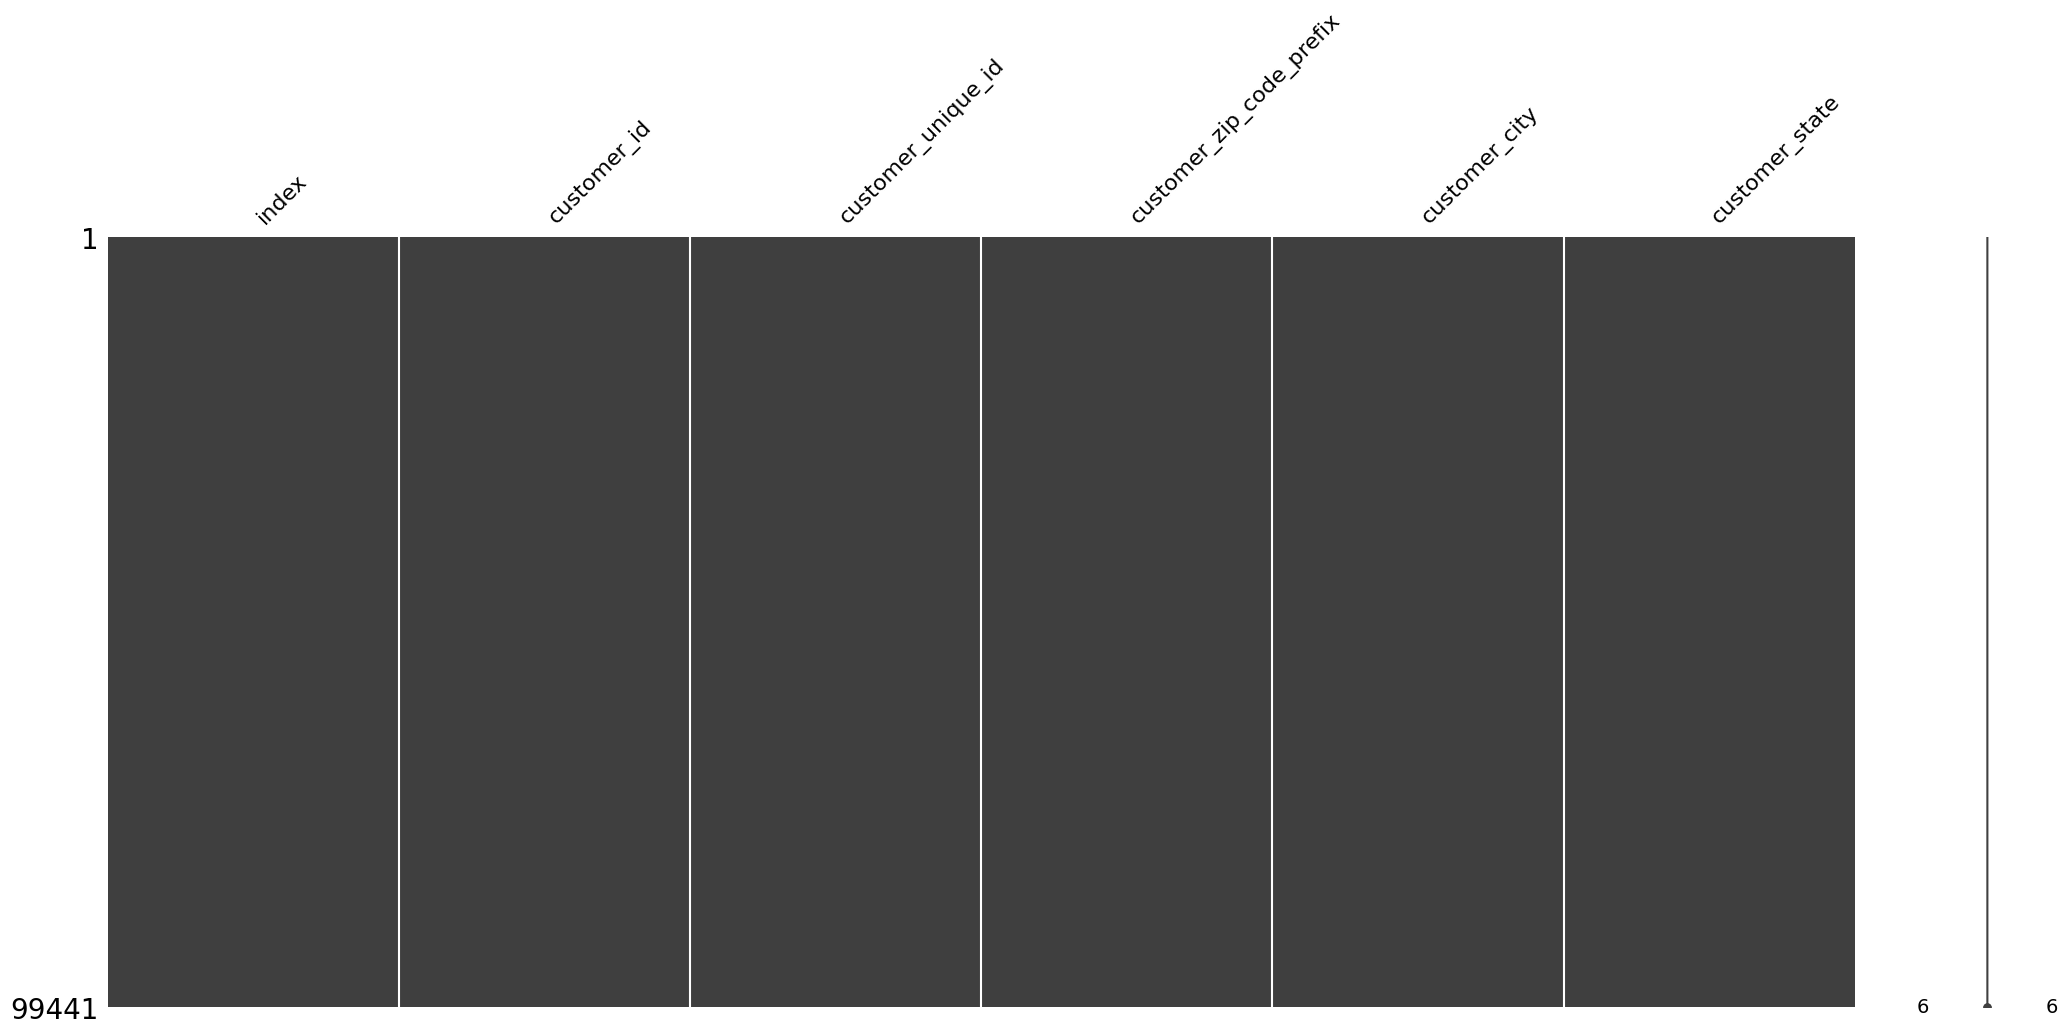

In [22]:
msno.matrix(customers)

## DF - Geoloc

In [23]:
geoloc.head()

,index,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,0,1037,-23.545621,-46.639292,sao paulo,SP
1,1,1046,-23.546081,-46.644820,sao paulo,SP
2,2,1046,-23.546129,-46.642951,sao paulo,SP
3,3,1041,-23.544392,-46.639499,sao paulo,SP
4,4,1035,-23.541578,-46.641607,sao paulo,SP


In [24]:
geoloc.tail()

,index,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1000158,1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,1000161,99980,-28.388932,-51.846871,david canabarro,RS
1000162,1000162,99950,-28.070104,-52.018658,tapejara,RS


In [25]:
geoloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   index                        1000163 non-null  int64  
 1   geolocation_zip_code_prefix  1000163 non-null  int64  
 2   geolocation_lat              1000163 non-null  float64
 3   geolocation_lng              1000163 non-null  float64
 4   geolocation_city             1000163 non-null  object 
 5   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 45.8+ MB


In [26]:
nb_lignes, nb_colonnes = geoloc.shape
type_colonnes = geoloc.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1000163
Nombre de colonnes : 6
Type des colonnes : 
int64      2
float64    2
object     2
Name: count, dtype: int64


In [27]:
geoloc.describe()

,index,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06,1.000163e+06
mean,5.000810e+05,3.657417e+04,-2.117615e+01,-4.639054e+01
std,2.887223e+05,3.054934e+04,5.715866e+00,4.269748e+00
min,0.000000e+00,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,2.500405e+05,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,5.000810e+05,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,7.501215e+05,6.350400e+04,-1.997962e+01,-4.376771e+01
max,1.000162e+06,9.999000e+04,4.506593e+01,1.211054e+02


<Axes: >

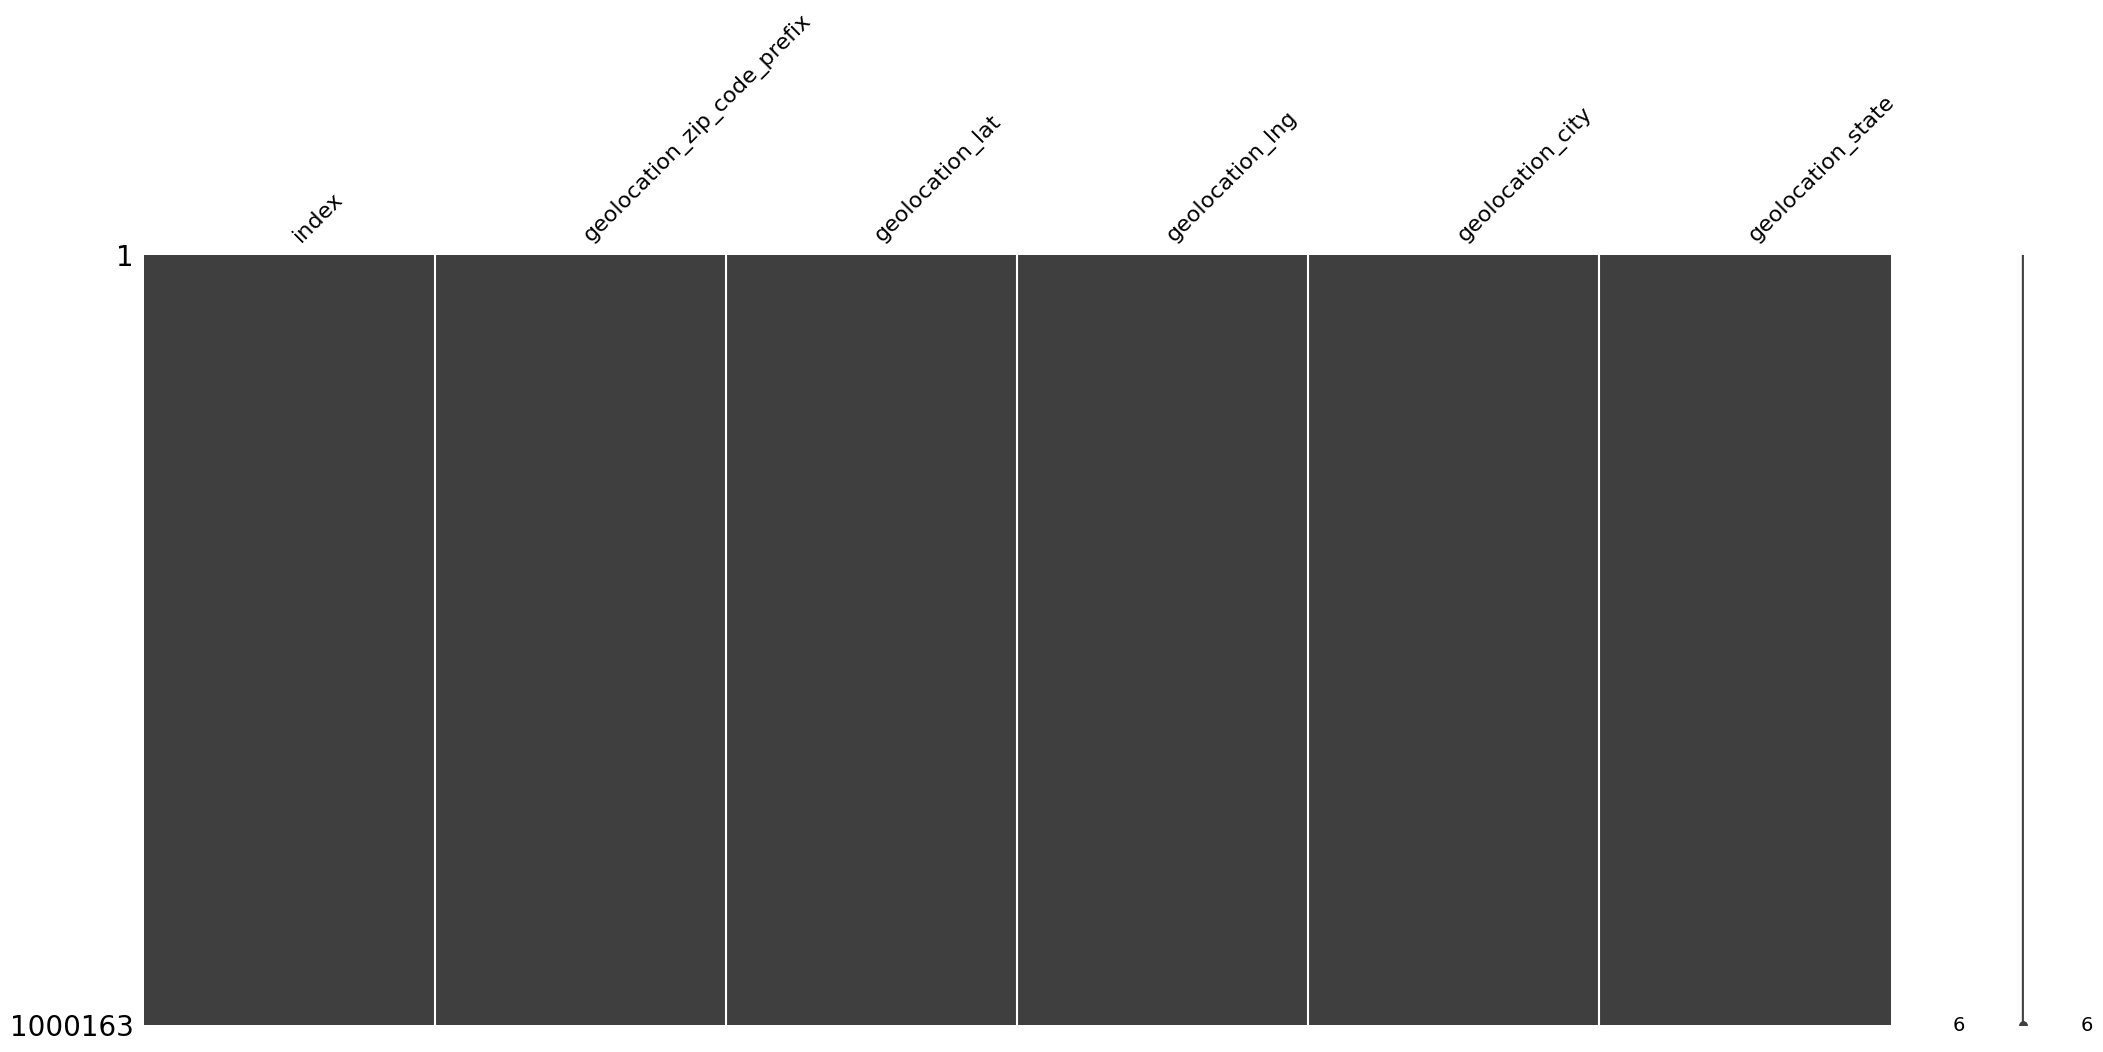

In [28]:
msno.matrix(geoloc)

## DF - Order Items

In [29]:
items.head()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [30]:
items.tail()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112645,112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112649,112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79


In [31]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


In [32]:
nb_lignes, nb_colonnes = items.shape
type_colonnes = items.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 112650
Nombre de colonnes : 8
Type des colonnes : 
object     4
int64      2
float64    2
Name: count, dtype: int64


In [33]:
items.describe()

,index,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000,112650.000000
mean,56324.500000,1.197834,120.653739,19.990320
std,32519.398249,0.705124,183.633928,15.806405
min,0.000000,1.000000,0.850000,0.000000
25%,28162.250000,1.000000,39.900000,13.080000
50%,56324.500000,1.000000,74.990000,16.260000
75%,84486.750000,1.000000,134.900000,21.150000
max,112649.000000,21.000000,6735.000000,409.680000


<Axes: >

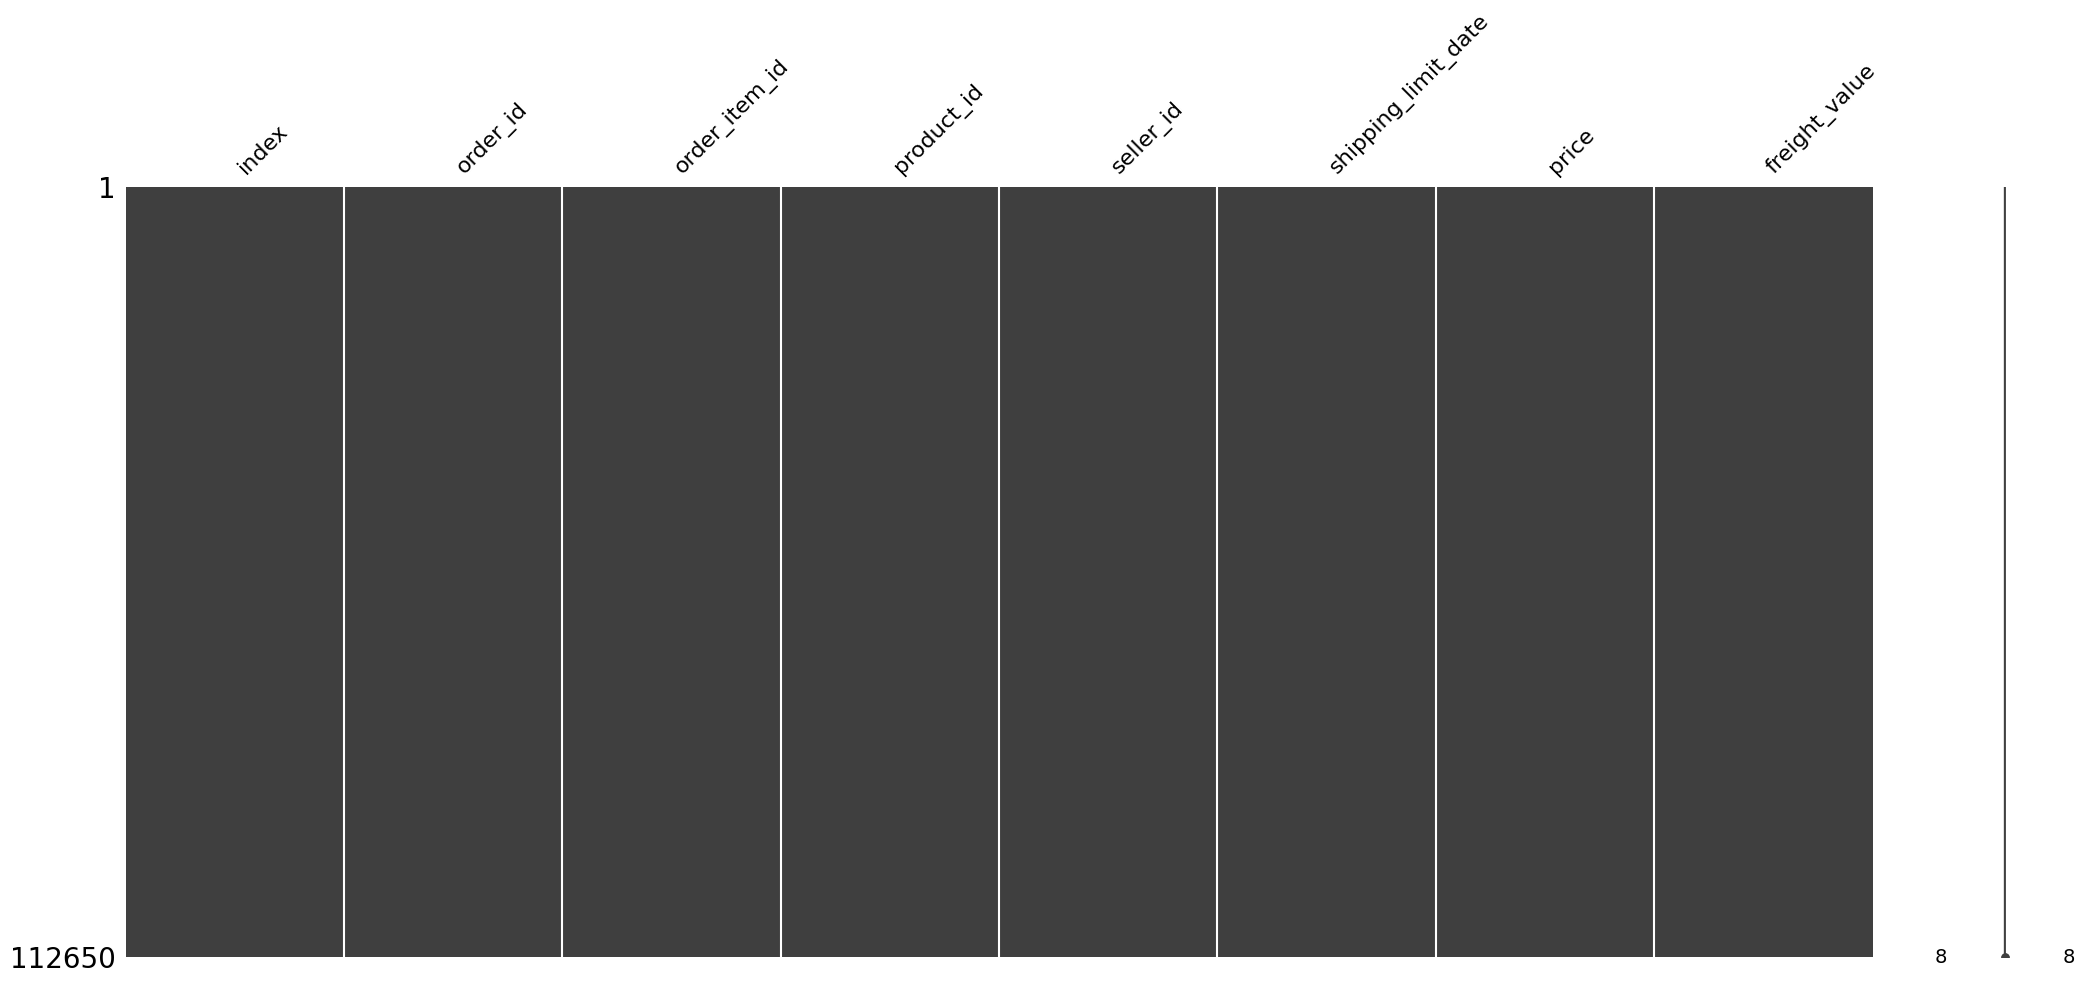

In [34]:
msno.matrix(items)

## DF - Order Pymts

In [35]:
pymts.head()

,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [36]:
pymts.tail()

,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
103881,103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54
103885,103885,28bbae6599b09d39ca406b747b6632b1,1,boleto,1,191.58


In [37]:
pymts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 103886 non-null  int64  
 1   order_id              103886 non-null  object 
 2   payment_sequential    103886 non-null  int64  
 3   payment_type          103886 non-null  object 
 4   payment_installments  103886 non-null  int64  
 5   payment_value         103886 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB


In [38]:
nb_lignes, nb_colonnes = pymts.shape
type_colonnes = pymts.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 103886
Nombre de colonnes : 6
Type des colonnes : 
int64      3
object     2
float64    1
Name: count, dtype: int64


In [39]:
pymts.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.092679,2.853349,154.100380
std,29989.44937,0.706584,2.687051,217.494064
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,4.000000,171.837500
max,103885.00000,29.000000,24.000000,13664.080000


<Axes: >

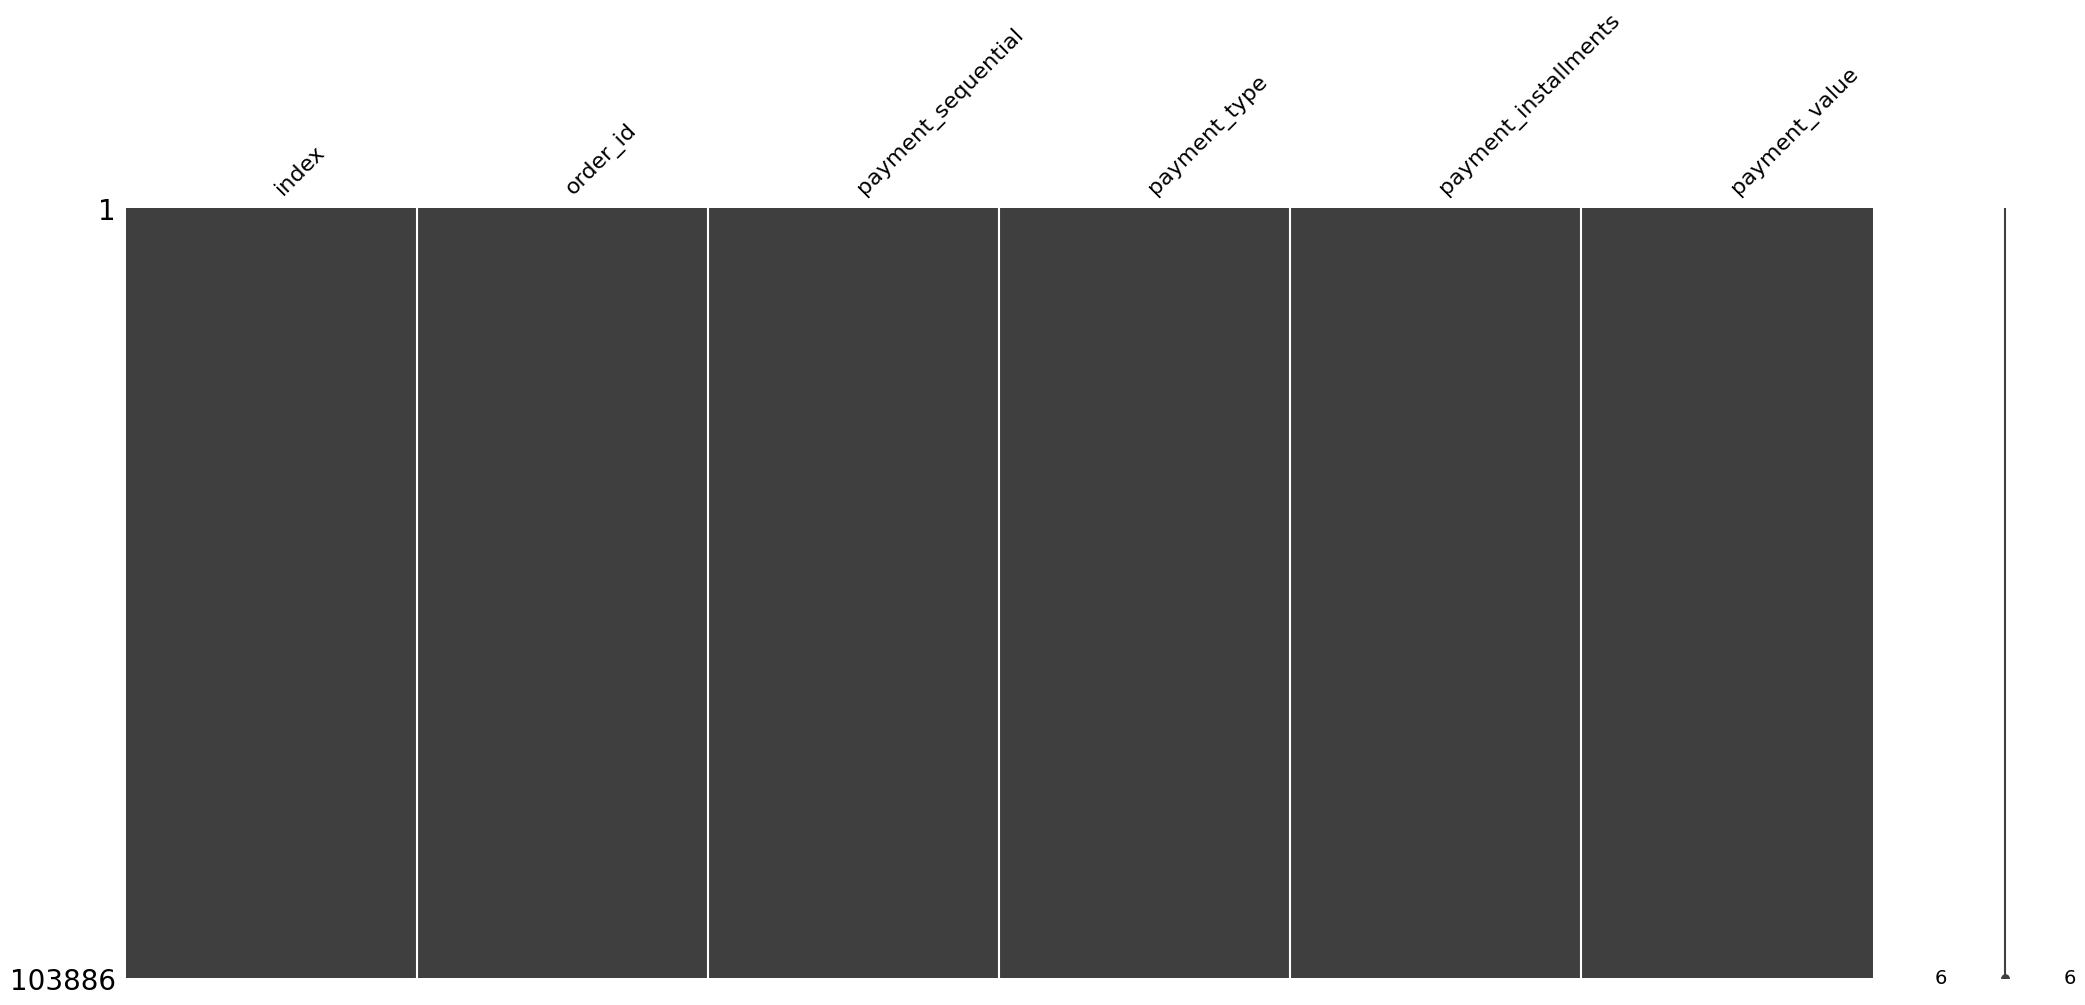

In [40]:
msno.matrix(pymts)

## DF - Order Reviews

In [41]:
reviews.head()

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [42]:
reviews.tail()

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
99219,99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99223,99223,efe49f1d6f951dd88b51e6ccd4cc548f,90531360ecb1eec2a1fbb265a0db0508,1,NaN,"meu produto chegou e ja tenho que devolver, po...",2017-07-03 00:00:00,2017-07-03 21:01:49


In [43]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    99224 non-null  int64 
 1   review_id                99224 non-null  object
 2   order_id                 99224 non-null  object
 3   review_score             99224 non-null  int64 
 4   review_comment_title     11568 non-null  object
 5   review_comment_message   40977 non-null  object
 6   review_creation_date     99224 non-null  object
 7   review_answer_timestamp  99224 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [44]:
nb_lignes, nb_colonnes = reviews.shape
type_colonnes = reviews.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 99224
Nombre de colonnes : 8
Type des colonnes : 
object    6
int64     2
Name: count, dtype: int64


In [45]:
reviews.describe()

,index,review_score
count,99224.000000,99224.000000
mean,49611.500000,4.086421
std,28643.645892,1.347579
min,0.000000,1.000000
25%,24805.750000,4.000000
50%,49611.500000,5.000000
75%,74417.250000,5.000000
max,99223.000000,5.000000


<Axes: >

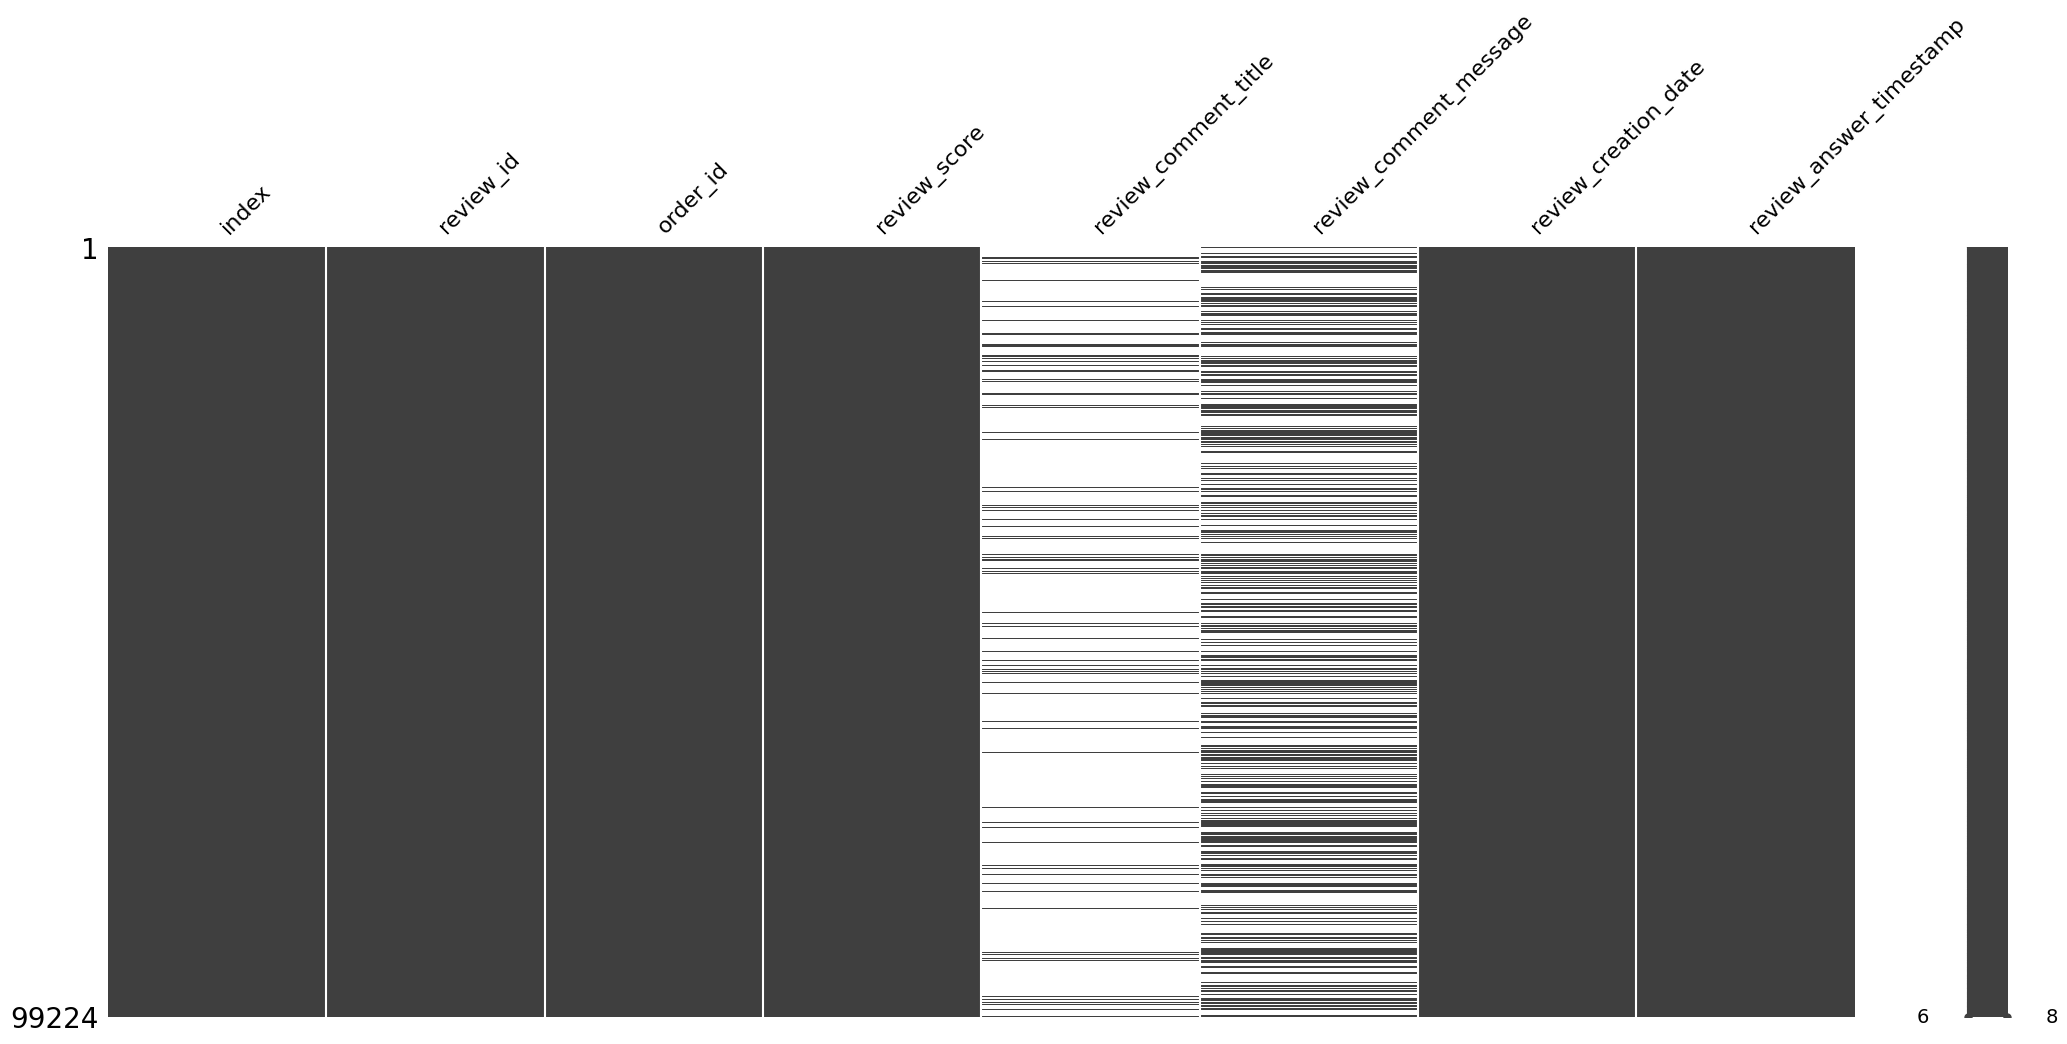

In [46]:
msno.matrix(reviews)

## DF - Orders

In [47]:
orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [48]:
orders.tail()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99436,99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00
99440,99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


In [49]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


In [50]:
nb_lignes, nb_colonnes = orders.shape
type_colonnes = orders.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 99441
Nombre de colonnes : 9
Type des colonnes : 
object    8
int64     1
Name: count, dtype: int64


In [51]:
orders.describe()

,index
count,99441.000000
mean,49720.000000
std,28706.288396
min,0.000000
25%,24860.000000
50%,49720.000000
75%,74580.000000
max,99440.000000


<Axes: >

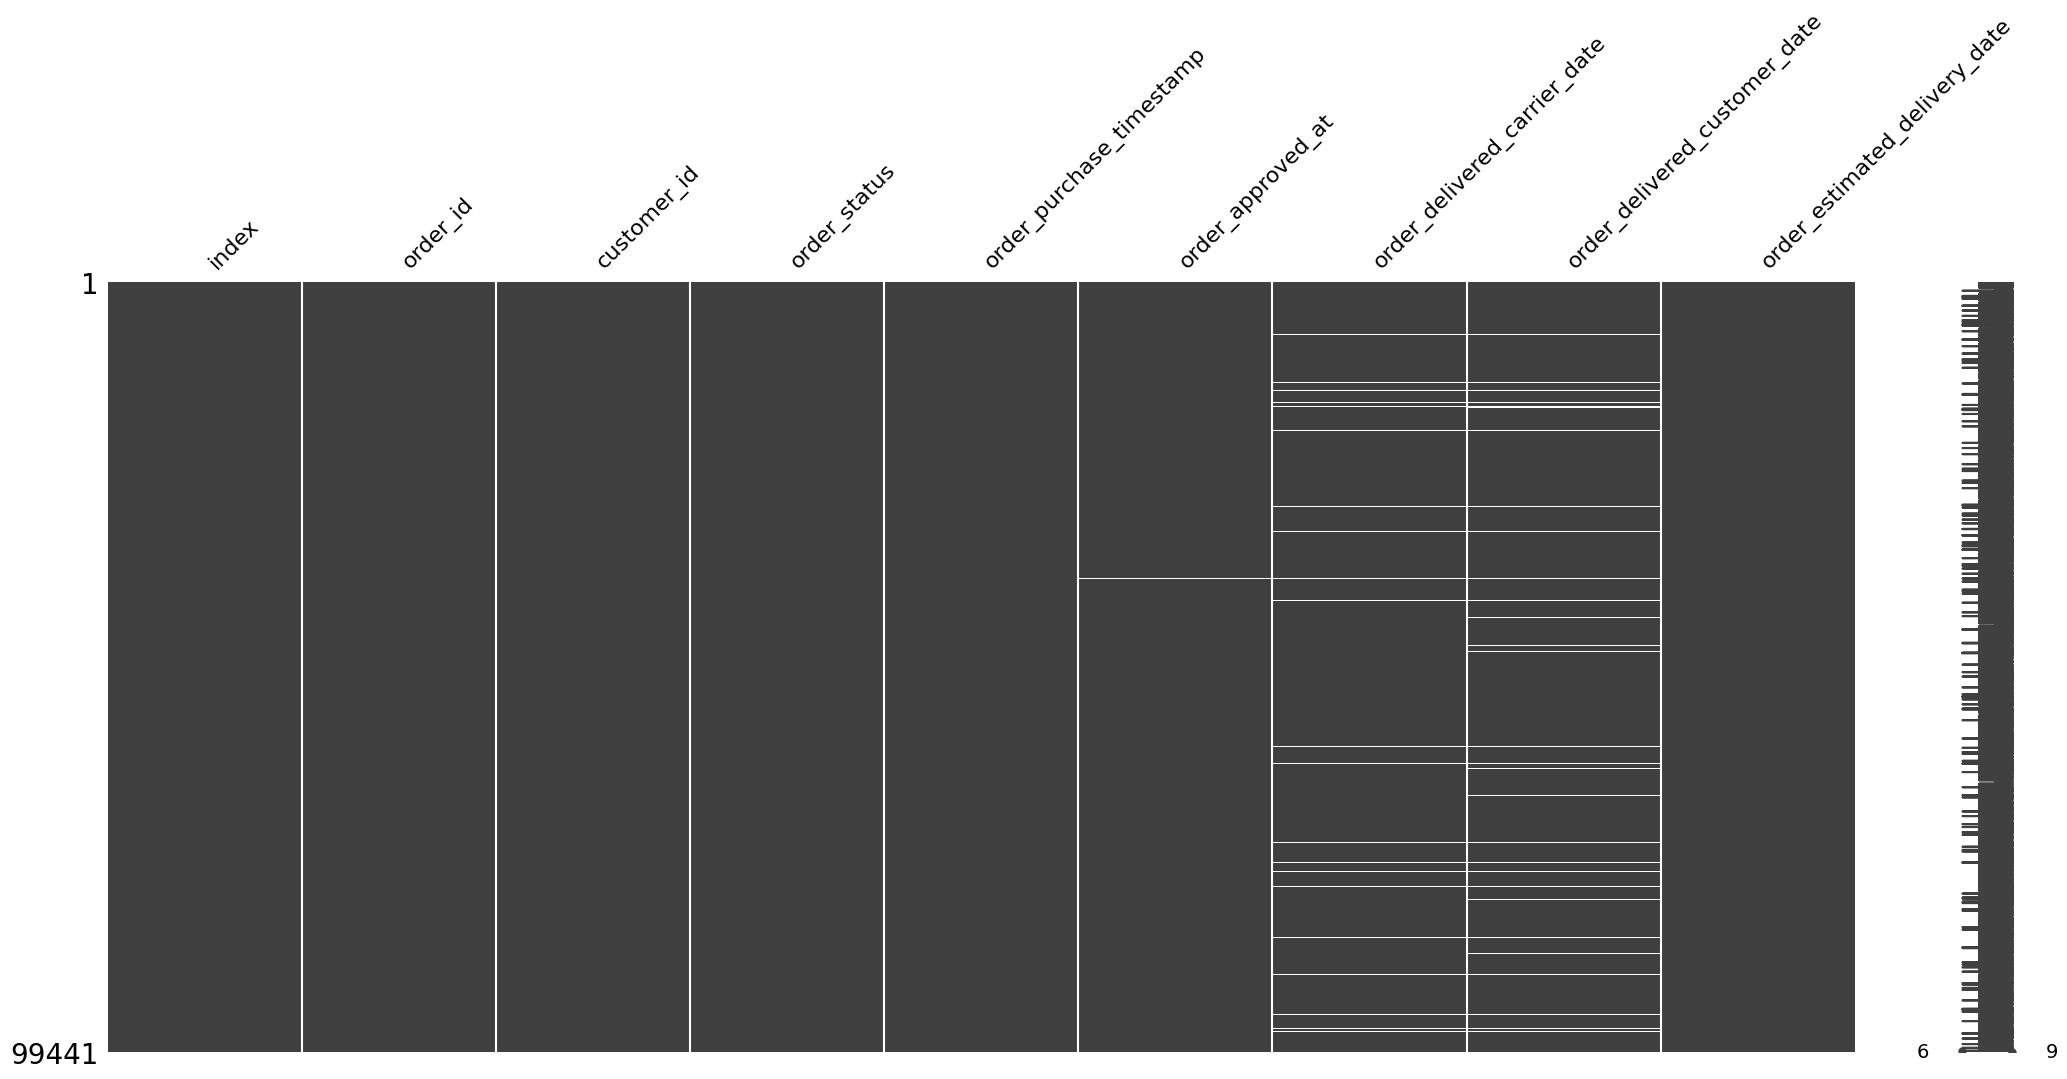

In [52]:
msno.matrix(orders)

## DF - Products

In [53]:
products.head()

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [54]:
products.tail()

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
32946,32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0
32950,32950,106392145fca363410d287a815be6de4,cama_mesa_banho,58.0,309.0,1.0,2083.0,12.0,2.0,7.0


In [55]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB


In [56]:
nb_lignes, nb_colonnes = products.shape
type_colonnes = products.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 32951
Nombre de colonnes : 10
Type des colonnes : 
float64    7
object     2
int64      1
Name: count, dtype: int64


In [57]:
products.describe()

,index,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951.000000,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,16475.000000,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,9512.278697,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,8237.500000,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,16475.000000,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,24712.500000,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,32950.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


<Axes: >

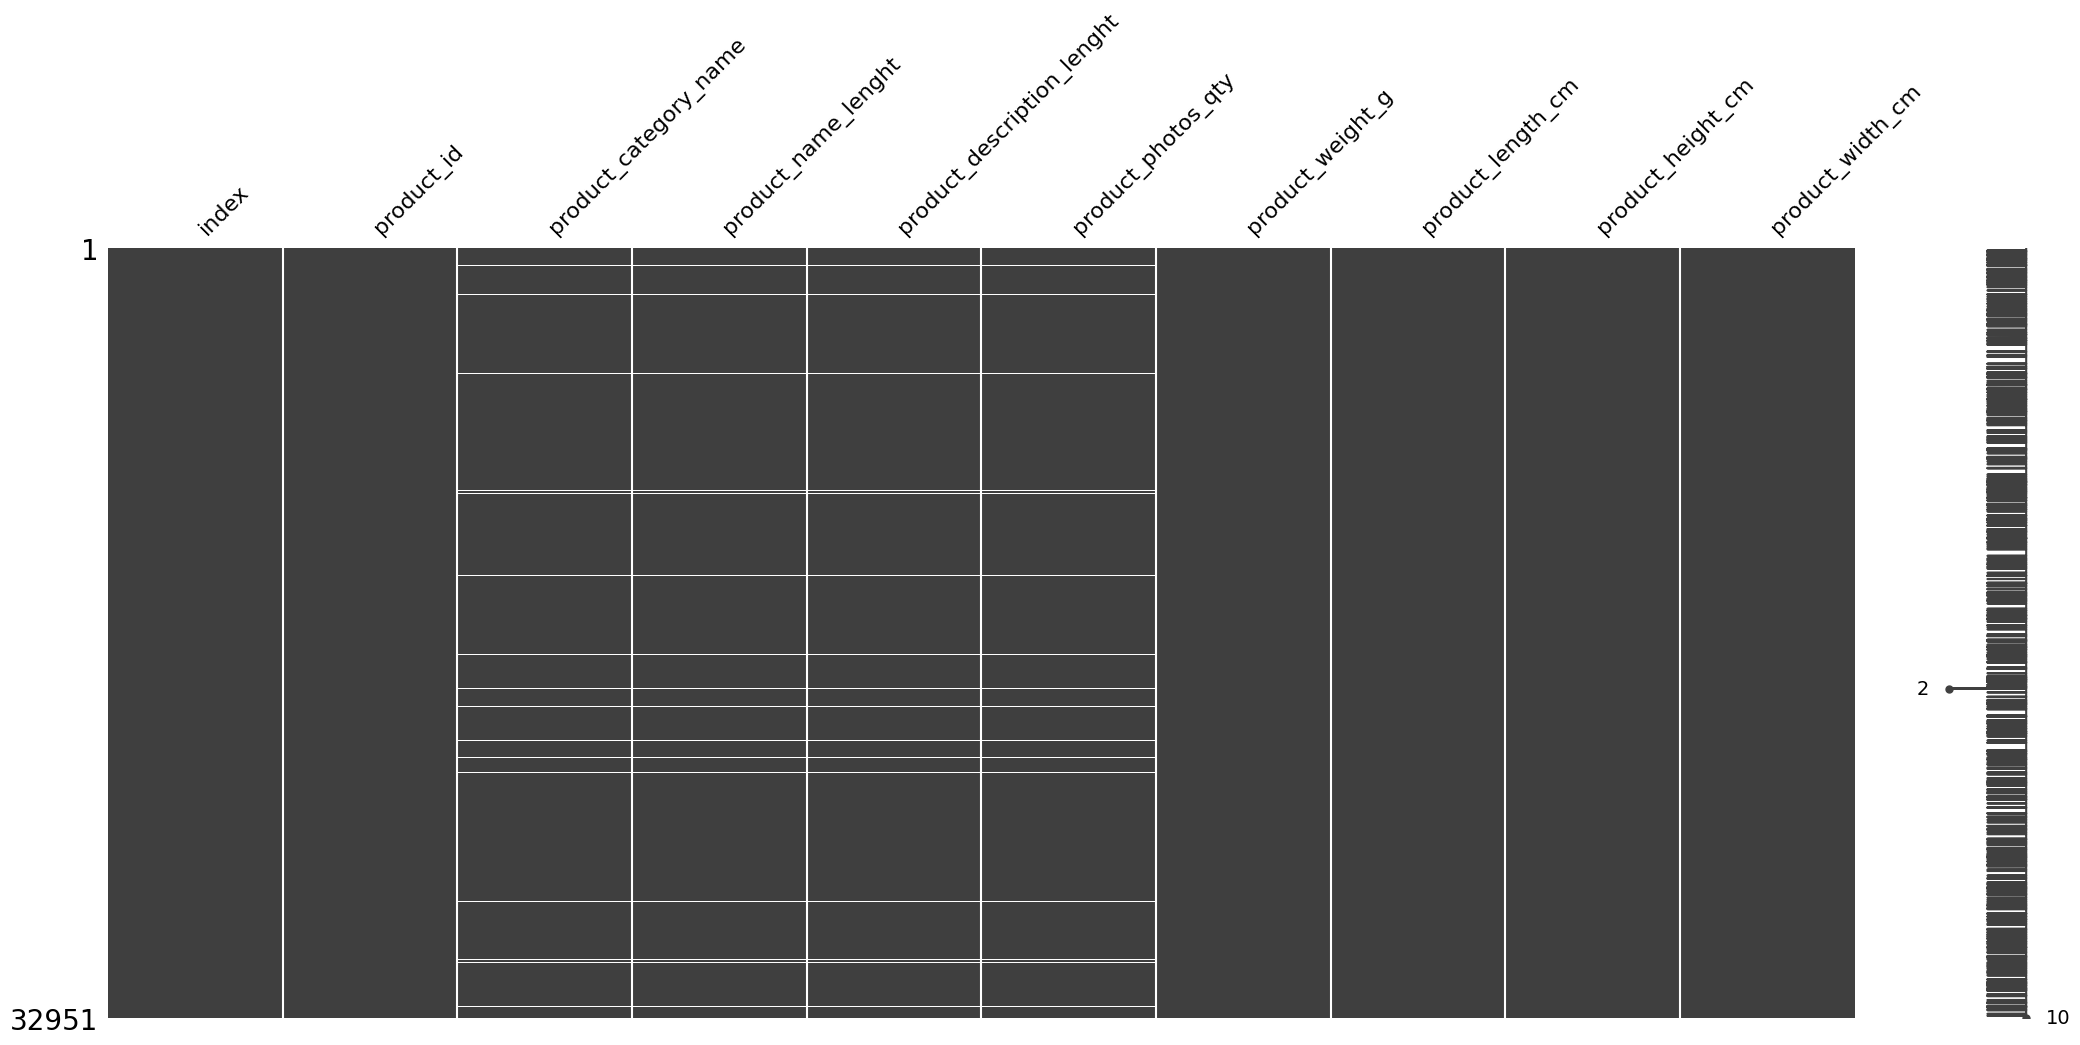

In [58]:
msno.matrix(products)

## DF - Sellers

In [59]:
sellers.head()

,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [60]:
sellers.tail()

,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
3090,3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS
3094,3094,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP


In [61]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   3095 non-null   int64 
 1   seller_id               3095 non-null   object
 2   seller_zip_code_prefix  3095 non-null   int64 
 3   seller_city             3095 non-null   object
 4   seller_state            3095 non-null   object
dtypes: int64(2), object(3)
memory usage: 121.0+ KB


In [62]:
nb_lignes, nb_colonnes = sellers.shape
type_colonnes = sellers.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 3095
Nombre de colonnes : 5
Type des colonnes : 
object    3
int64     2
Name: count, dtype: int64


In [63]:
sellers.describe()

,index,seller_zip_code_prefix
count,3095.000000,3095.000000
mean,1547.000000,32291.059451
std,893.593867,32713.453830
min,0.000000,1001.000000
25%,773.500000,7093.500000
50%,1547.000000,14940.000000
75%,2320.500000,64552.500000
max,3094.000000,99730.000000


<Axes: >

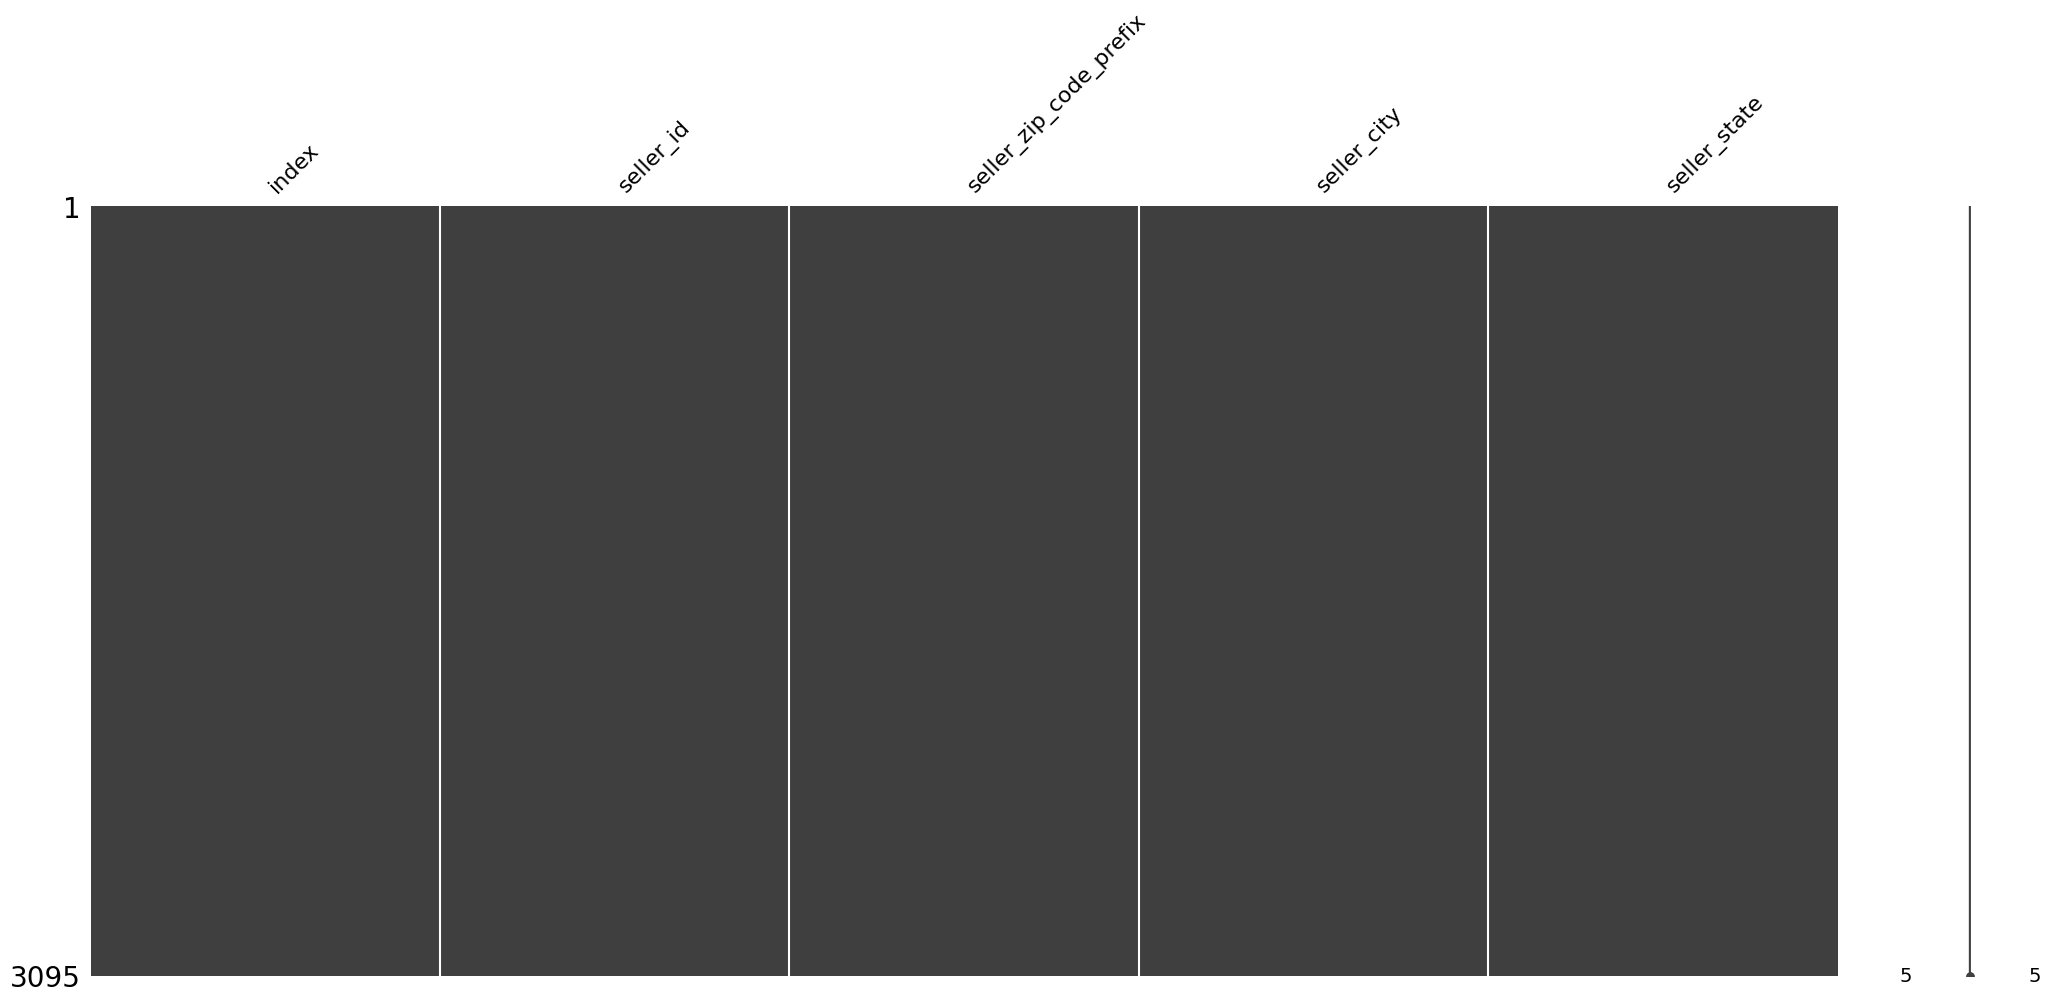

In [64]:
msno.matrix(sellers)

## DF - Translation

In [65]:
translation.head()

,index,product_category_name,product_category_name_english
0,0,beleza_saude,health_beauty
1,1,informatica_acessorios,computers_accessories
2,2,automotivo,auto
3,3,cama_mesa_banho,bed_bath_table
4,4,moveis_decoracao,furniture_decor


In [66]:
translation.tail()

,index,product_category_name,product_category_name_english
66,66,flores,flowers
67,67,artes_e_artesanato,arts_and_craftmanship
68,68,fraldas_higiene,diapers_and_hygiene
69,69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,70,seguros_e_servicos,security_and_services


In [67]:
translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          71 non-null     int64 
 1   product_category_name          71 non-null     object
 2   product_category_name_english  71 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


In [68]:
nb_lignes, nb_colonnes = translation.shape
type_colonnes = translation.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 71
Nombre de colonnes : 3
Type des colonnes : 
object    2
int64     1
Name: count, dtype: int64


In [69]:
translation.describe()

,index
count,71.000000
mean,35.000000
std,20.639767
min,0.000000
25%,17.500000
50%,35.000000
75%,52.500000
max,70.000000


<Axes: >

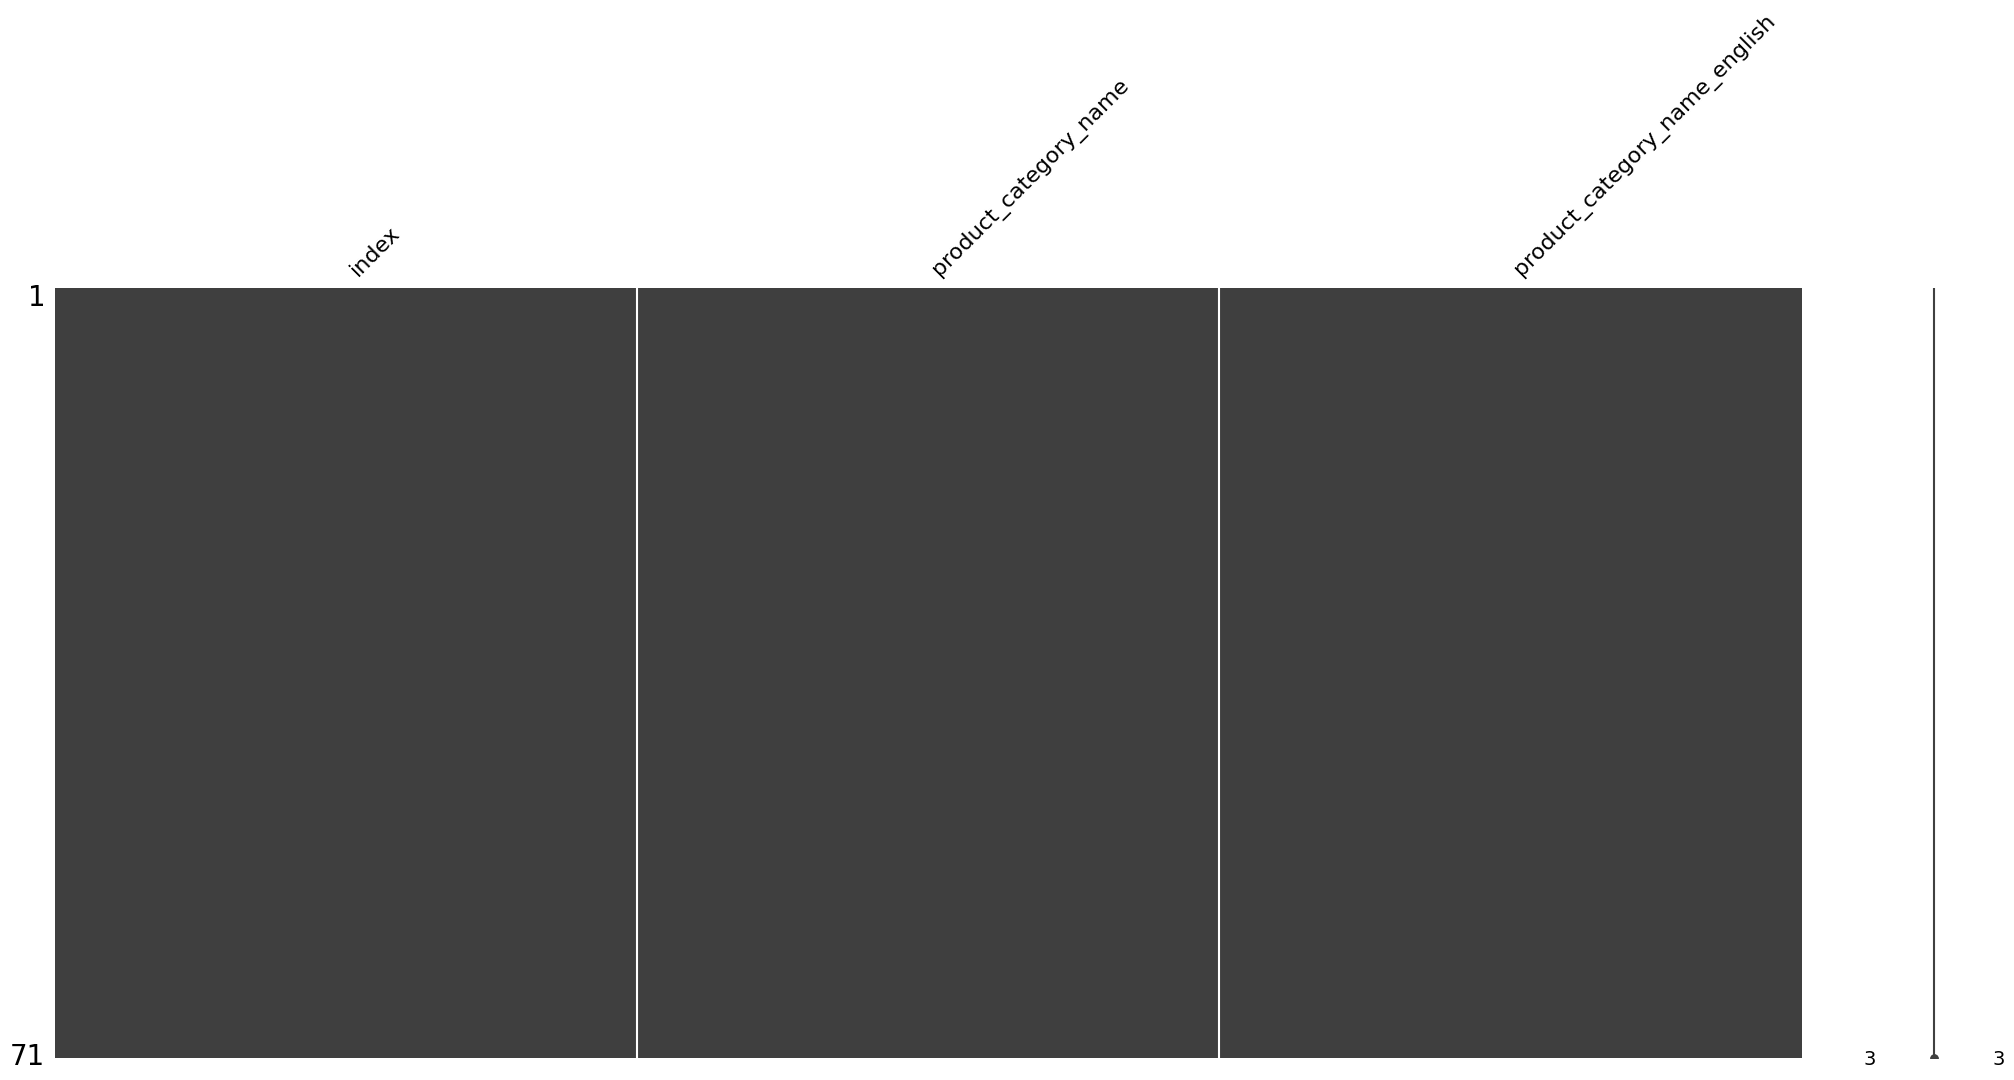

In [70]:
msno.matrix(translation)

In [71]:
olist_db.head()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,table_name,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409.0,franca,SP,customers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790.0,sao bernardo do campo,SP,customers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151.0,sao paulo,SP,customers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775.0,mogi das cruzes,SP,customers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056.0,campinas,SP,customers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
olist_db.tail()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,table_name,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
1550917,66,NaN,NaN,NaN,NaN,NaN,translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flores,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flowers
1550918,67,NaN,NaN,NaN,NaN,NaN,translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,artes_e_artesanato,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,arts_and_craftmanship
1550919,68,NaN,NaN,NaN,NaN,NaN,translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fraldas_higiene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,diapers_and_hygiene
1550920,69,NaN,NaN,NaN,NaN,NaN,translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fashion_roupa_infanto_juvenil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fashion_childrens_clothes
1550921,70,NaN,NaN,NaN,NaN,NaN,translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,seguros_e_servicos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,security_and_services


In [73]:
olist_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550922 entries, 0 to 1550921
Data columns (total 47 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   index                          1550922 non-null  int64  
 1   customer_id                    198882 non-null   object 
 2   customer_unique_id             99441 non-null    object 
 3   customer_zip_code_prefix       99441 non-null    float64
 4   customer_city                  99441 non-null    object 
 5   customer_state                 99441 non-null    object 
 6   table_name                     1550922 non-null  object 
 7   geolocation_zip_code_prefix    1000163 non-null  float64
 8   geolocation_lat                1000163 non-null  float64
 9   geolocation_lng                1000163 non-null  float64
 10  geolocation_city               1000163 non-null  object 
 11  geolocation_state              1000163 non-null  object 
 12  order_id      

In [74]:
nb_lignes, nb_colonnes = olist_db.shape
type_colonnes = olist_db.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1550922
Nombre de colonnes : 47
Type des colonnes : 
object     27
float64    19
int64       1
Name: count, dtype: int64


In [75]:
olist_db.describe()

,index,customer_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
count,1.550922e+06,99441.000000,1.000163e+06,1.000163e+06,1.000163e+06,112650.000000,112650.000000,112650.000000,103886.000000,103886.000000,103886.000000,99224.000000,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000,3095.000000
mean,3.399670e+05,35137.474583,3.657417e+04,-2.117615e+01,-4.639054e+01,1.197834,120.653739,19.990320,1.092679,2.853349,154.100380,4.086421,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728,32291.059451
std,3.172408e+05,29797.938996,3.054934e+04,5.715866e+00,4.269748e+00,0.705124,183.633928,15.806405,0.706584,2.687051,217.494064,1.347579,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047,32713.453830
min,0.000000e+00,1003.000000,1.001000e+03,-3.660537e+01,-1.014668e+02,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000
25%,5.860200e+04,11347.000000,1.107500e+04,-2.360355e+01,-4.857317e+01,1.000000,39.900000,13.080000,1.000000,1.000000,56.790000,4.000000,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000,7093.500000
50%,2.247015e+05,24416.000000,2.653000e+04,-2.291938e+01,-4.663788e+01,1.000000,74.990000,16.260000,1.000000,1.000000,100.000000,5.000000,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000,14940.000000
75%,6.124318e+05,58900.000000,6.350400e+04,-1.997962e+01,-4.376771e+01,1.000000,134.900000,21.150000,1.000000,4.000000,171.837500,5.000000,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000,64552.500000
max,1.000162e+06,99990.000000,9.999000e+04,4.506593e+01,1.211054e+02,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000


<Axes: >

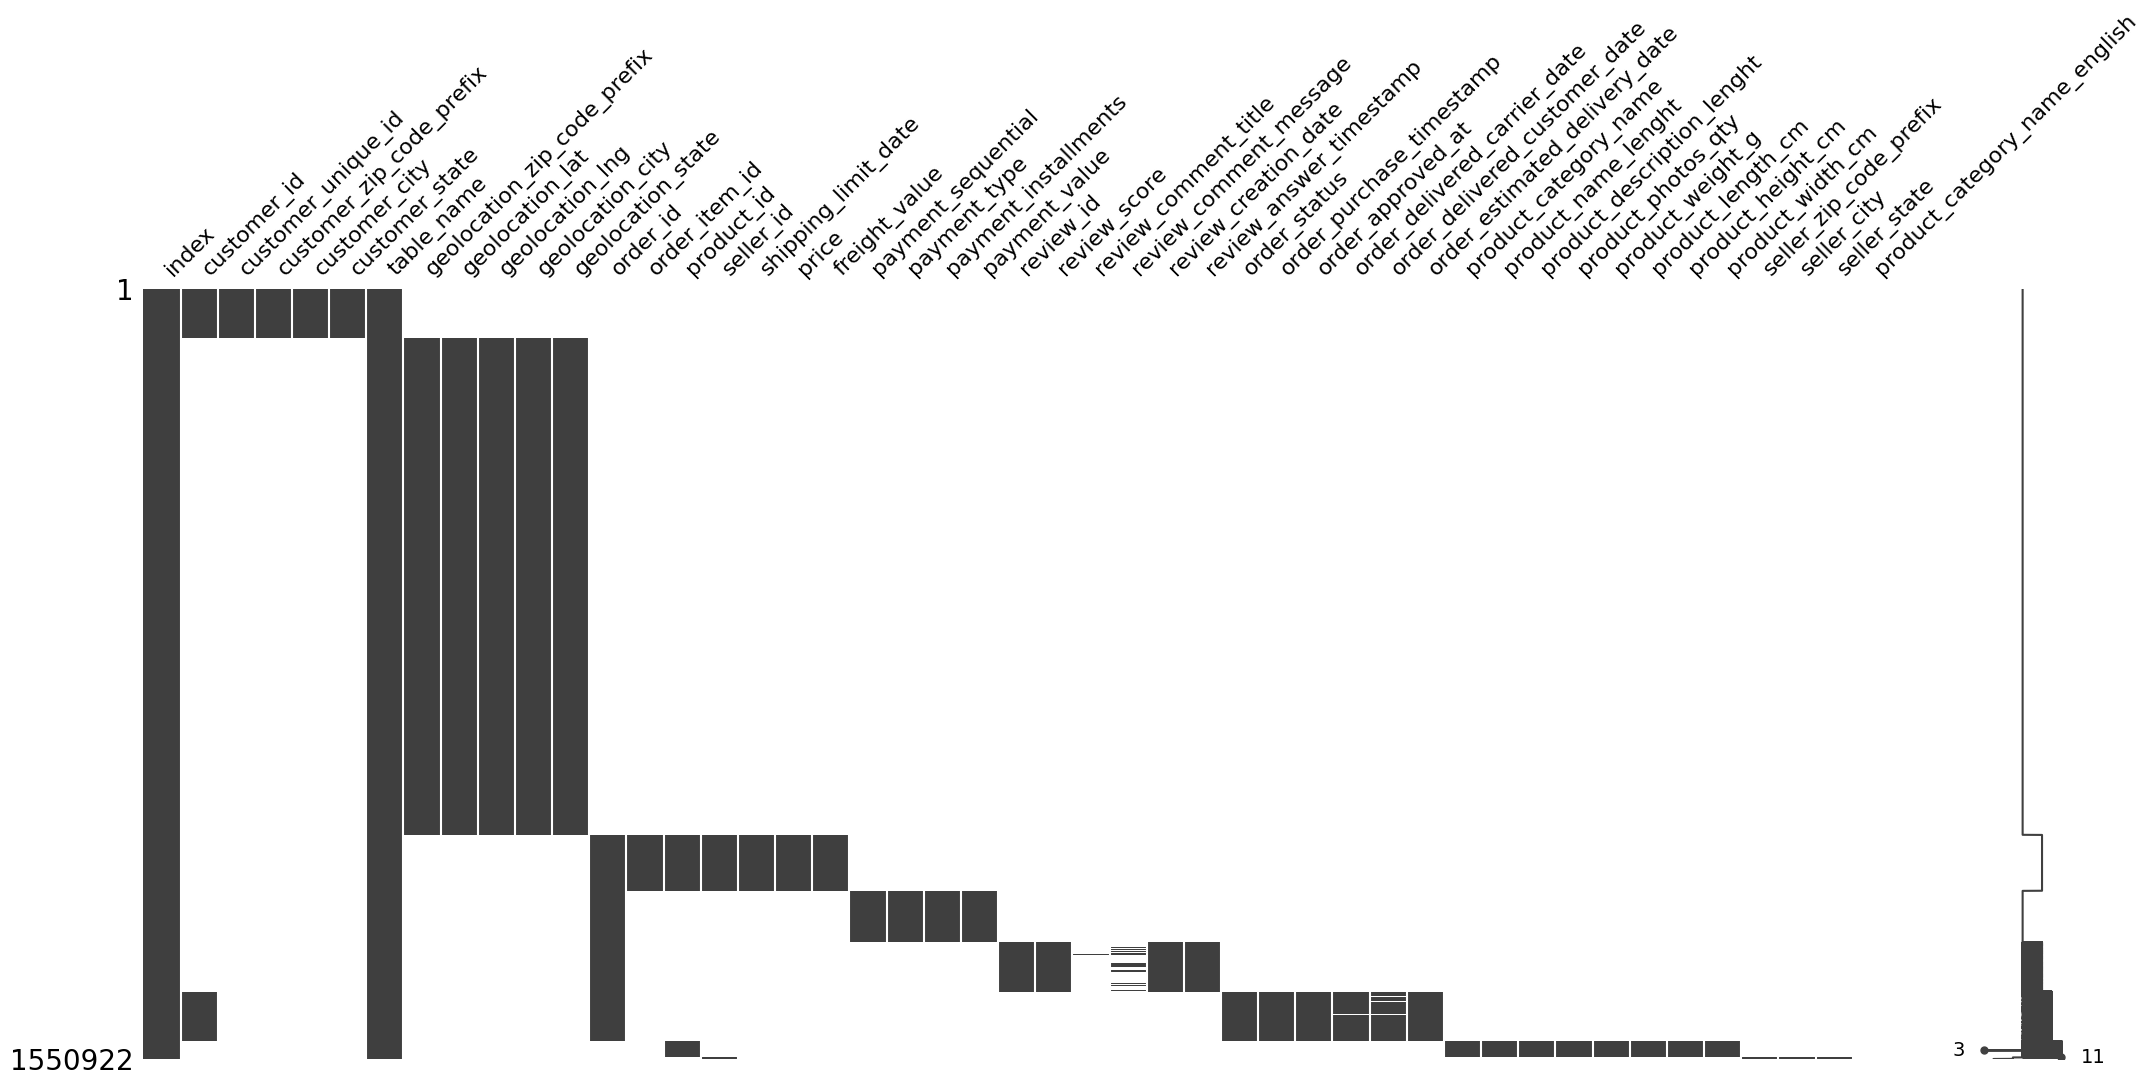

In [76]:
msno.matrix(olist_db)

### Merge des datasets en data

In [77]:
data = pd.DataFrame()

data = orders.merge(customers, on="customer_id", how="right", suffixes=("_orders", "_customers"))
data = data.merge(items, on="order_id", how="outer", suffixes=("_orders", "_items"))
data = data.merge(pymts, on="order_id", how="outer", suffixes=("_items", "_pymts"))
data = data.merge(reviews, on="order_id", how="outer", suffixes=("_pymts", "_reviews"))
data = data.merge(products, on="product_id", how="outer", suffixes=("_reviews", "_products"))
data = data.merge(sellers, on="seller_id", how="outer", suffixes=("_products", "_sellers"))
data = data.merge(translation, on="product_category_name", how="outer", suffixes=("_sellers", "_translation"))

In [78]:
data.head()

,index_orders,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customers,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_items,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index_pymts,payment_sequential,payment_type,payment_installments,payment_value,index_reviews,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index_products,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_sellers,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english
0,80504,b02f2888891cd431e71f2f0a9a85e7b8,53d5e3e5a2eb022edd3570dde355947b,delivered,2018-04-28 23:14:00,2018-05-01 02:10:24,2018-05-02 15:14:00,2018-05-04 00:03:45,2018-05-16 00:00:00,64770,03a4abdc6deb7b5b3c18b4cde6d63761,7500,santa isabel,SP,77401.0,1.0,0b2a1288e8ba64c797e7586c8df75602,06579cb253ecd5a3a12a9e6eb6bf8f47,2018-05-07 02:10:24,96.9,7.54,15106.0,1.0,boleto,1.0,104.44,84221.0,7e2dea23a52b5601773bf9e2ea9e6b91,5.0,Muito bom e pratico.,Otimo produto pro dia a dia.\r\n,2018-05-05 00:00:00,2018-05-07 22:23:20,4003.0,agro_industria_e_comercio,38.0,397.0,1.0,3450.0,33.0,36.0,33.0,2946.0,4007.0,sao paulo - sp,SP,37.0,agro_industry_and_commerce
1,96106,73455801790c8a31e404a3d4861f3d61,d04b1ea9de553c20d8315f98cf8289a2,delivered,2017-12-10 23:01:37,2017-12-10 23:17:27,2017-12-11 23:25:37,2017-12-20 16:48:51,2017-12-28 00:00:00,91729,d3beb4deb410a98b8f5406a88aa1ad94,13206,jundiai,SP,50699.0,1.0,3a2b04bd67f105099d662e522bec56e9,06579cb253ecd5a3a12a9e6eb6bf8f47,2017-12-14 23:17:27,89.9,7.88,57253.0,1.0,credit_card,9.0,97.78,7793.0,9e64f0997df9ff040667677751c4030a,4.0,NaN,NaN,2017-12-21 00:00:00,2017-12-31 12:29:11,26727.0,agro_industria_e_comercio,38.0,397.0,1.0,3275.0,35.0,37.0,19.0,2946.0,4007.0,sao paulo - sp,SP,37.0,agro_industry_and_commerce
2,77913,9df16fc9c0296bef63c2effb85d6969c,7dfcf04eef8eb511409413ca6bed1fed,delivered,2018-06-25 21:02:52,2018-06-25 21:15:26,2018-06-27 11:32:00,2018-07-12 22:11:16,2018-08-02 00:00:00,36853,9b6839b18c37508b3a07fdec4c9572c0,62350,ubajara,CE,69162.0,1.0,1df0508de978ce519aa5533ae04154c7,0ed6ce5d87fd9c69eaacaeb778d67235,2018-07-04 21:15:26,124.9,43.15,26880.0,1.0,credit_card,3.0,168.05,33670.0,f2d2620c4423b341b38a58c3a0caa022,5.0,10,NaN,2018-07-13 00:00:00,2018-07-14 22:03:39,28989.0,agro_industria_e_comercio,59.0,707.0,5.0,1900.0,40.0,15.0,20.0,2078.0,13473.0,americana,SP,37.0,agro_industry_and_commerce
3,18100,b787106d477dcf42be86fc2e8eabdaab,e05b37c1692ca2dc95dbcfefebd59a4d,delivered,2018-05-07 20:39:54,2018-05-07 20:55:29,2018-05-09 10:00:00,2018-05-24 17:25:37,2018-05-30 00:00:00,92284,74fb5bcd75ea556233c22200d3ac9c22,24715,sao goncalo,RJ,80698.0,1.0,52510930c23a1b9c337a0a9306a3645c,0ed6ce5d87fd9c69eaacaeb778d67235,2018-05-16 20:55:29,269.9,24.43,81604.0,1.0,credit_card,3.0,294.33,91216.0,b0afc651d3b29418a4438c1ed354a960,5.0,NaN,NaN,2018-05-25 00:00:00,2018-05-29 02:30:54,14252.0,agro_industria_e_comercio,54.0,790.0,4.0,3000.0,50.0,20.0,30.0,2078.0,13473.0,americana,SP,37.0,agro_industry_and_commerce
4,88790,5e0ff060a686922559e33f8dbe998e41,ba03825db0f92dbade0ec0278a6e26ae,delivered,2018-07-24 21:30:58,2018-07-24 21:45:09,2018-08-09 15:19:00,2018-08-13 19:16:51,2018-08-15 00:00:00,29729,7f4b3e37f62fd76ce20deebe1f898718,16901,andradina,SP,41295.0,1.0,ba1d7e7ee1f055d252a2faa8ea3cea9b,0ed6ce5d87fd9c69eaacaeb778d67235,2018-08-05 21:45:09,109.9,15.08,58700.0,1.0,credit_card,2.0,124.98,24855.0,9f98c17fd117aef60d72f3f94338232e,5.0,NaN,NaN,2018-08-14 00:00:00,2018-08-17 00:38:22,1412.0,agro_industria_e_comercio,59.0,693.0,6.0,1900.0,45.0,15.0,40.0,2078.0,13473.0,americana,SP,37.0,agro_industry_and_commerce


In [79]:
data.tail()

,index_orders,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customers,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_items,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index_pymts,payment_sequential,payment_type,payment_installments,payment_value,index_reviews,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index_products,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_sellers,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english
119138,88392,fdcca0e15a4d03e3fb89fb14664a3744,58ee086556a160d66dc3f6d43b4efcc3,unavailable,2017-09-11 20:02:08,2017-09-11 20:15:25,NaN,NaN,2017-10-02 00:00:00,92900,3ba7980dfa14cd3508fa58c4198ce202,27600,valenca,RJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94800.0,1.0,credit_card,2.0,29.59,77309.0,b9e318ef0f1cc3d0dad1d7fb709efd71,4.0,NaN,NaN,2017-10-04 00:00:00,2017-10-07 19:42:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119139,61608,fddbd183387b5c9bcbafbd0fe965301f,bade46d49478a63c01dca6a9ae49dfa9,unavailable,2017-09-23 10:25:00,2017-09-26 03:24:31,NaN,NaN,2017-10-18 00:00:00,8798,ab1284d4947ed16ddcc55a7f06f13c63,82310,curitiba,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70446.0,1.0,boleto,1.0,40.00,98953.0,1ddd65e557c027e7df4a50416417a2e4,1.0,NaN,Só quero meu dinheiro de volta porque o pedido...,2017-10-21 00:00:00,2017-10-21 13:54:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119140,40833,fe87d4b944748f63ca5ed22cc55b6fb6,d992eb012e1599214218191d39c99693,unavailable,2017-12-05 09:20:36,2017-12-05 15:14:07,NaN,NaN,2017-12-21 00:00:00,54349,876e013b5aba25a55b55a4d5670ba831,2975,sao paulo,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,1.0,debit_card,1.0,173.68,85123.0,09da9d59b735d9a7be5730b7478f6a8d,1.0,NaN,NaN,2017-12-22 00:00:00,2017-12-22 09:19:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119141,10180,feae5ecdf2cc16c1007741be785fe3cd,ca05f8b53b1ad2a64bf34baa8aa7f4f6,unavailable,2017-11-11 16:41:06,2017-11-11 16:56:15,NaN,NaN,2017-11-27 00:00:00,33088,7bc4575824e6804ddbe418bf4ad08079,6803,embu das artes,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8383.0,1.0,credit_card,1.0,68.53,58596.0,9ca5401128a3ced3fb0fd3abe00940bc,1.0,NaN,Vendeu-me o mesmo produto (calha de chuva do H...,2017-11-29 00:00:00,2017-11-29 11:49:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119142,40171,ff71fa43cf5b726cd4a5763c7d819a35,14217d5d9e2e67faaae493aa0a181d4c,unavailable,2017-07-19 21:53:57,2017-07-21 02:50:44,NaN,NaN,2017-08-10 00:00:00,68917,a2592dc4cd6eb20010c6002ccfa05b90,17900,dracena,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81123.0,1.0,boleto,1.0,81.89,82381.0,62fc4a26d6a47c33586e4aebe50f833a,1.0,NaN,Após transtornos com a primeira compra recebi ...,2017-08-16 00:00:00,2017-08-16 16:31:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_orders                   119143 non-null  int64  
 1   order_id                       119143 non-null  object 
 2   customer_id                    119143 non-null  object 
 3   order_status                   119143 non-null  object 
 4   order_purchase_timestamp       119143 non-null  object 
 5   order_approved_at              118966 non-null  object 
 6   order_delivered_carrier_date   117057 non-null  object 
 7   order_delivered_customer_date  115722 non-null  object 
 8   order_estimated_delivery_date  119143 non-null  object 
 9   index_customers                119143 non-null  int64  
 10  customer_unique_id             119143 non-null  object 
 11  customer_zip_code_prefix       119143 non-null  int64  
 12  customer_city                 

In [81]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 119143
Nombre de colonnes : 48
Type des colonnes : 
object     24
float64    21
int64       3
Name: count, dtype: int64


In [82]:
data.describe()

,index_orders,index_customers,customer_zip_code_prefix,index_items,order_item_id,price,freight_value,index_pymts,payment_sequential,payment_installments,payment_value,index_reviews,review_score,index_products,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_sellers,seller_zip_code_prefix,index_translation
count,119143.000000,119143.000000,119143.000000,118310.000000,118310.000000,118310.000000,118310.000000,119140.000000,119140.000000,119140.000000,119140.000000,118146.000000,118146.000000,118310.000000,116601.000000,116601.000000,116601.000000,118290.000000,118290.000000,118290.000000,118290.000000,118310.000000,118310.000000,116576.000000
mean,49784.072501,49685.621228,35033.451298,56272.832051,1.196543,120.646603,20.032387,51954.378068,1.094737,2.941246,172.735135,49607.881663,4.015582,16554.845710,48.767498,785.967822,2.205161,2112.250740,30.265145,16.619706,23.074799,1521.878168,24442.410413,11.433871
std,28737.471112,28696.567992,29823.198969,32529.558212,0.699489,184.109691,15.836850,29983.799703,0.730141,2.777848,267.776077,28652.001077,1.400436,9568.574716,10.033540,652.584121,1.717452,3786.695111,16.189367,13.453584,11.749139,878.954106,27573.004511,12.430655
min,0.000000,0.000000,1003.000000,0.000000,1.000000,0.850000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.000000,1001.000000,0.000000
25%,24878.500000,24850.500000,11250.000000,28100.250000,1.000000,39.900000,13.080000,26016.750000,1.000000,1.000000,60.850000,24808.250000,4.000000,8290.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,728.000000,6429.000000,3.000000
50%,49744.000000,49722.000000,24240.000000,56218.500000,1.000000,74.900000,16.280000,51974.500000,1.000000,2.000000,108.160000,49587.500000,5.000000,16401.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1529.000000,13660.000000,7.000000
75%,74712.500000,74481.500000,58475.000000,84480.750000,1.000000,134.900000,21.180000,77882.250000,1.000000,4.000000,189.240000,74349.750000,5.000000,24974.000000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,2290.000000,27972.000000,16.000000
max,99440.000000,99440.000000,99990.000000,112649.000000,21.000000,6735.000000,409.680000,103885.000000,29.000000,24.000000,13664.080000,99223.000000,5.000000,32950.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,3094.000000,99730.000000,70.000000


<Axes: >

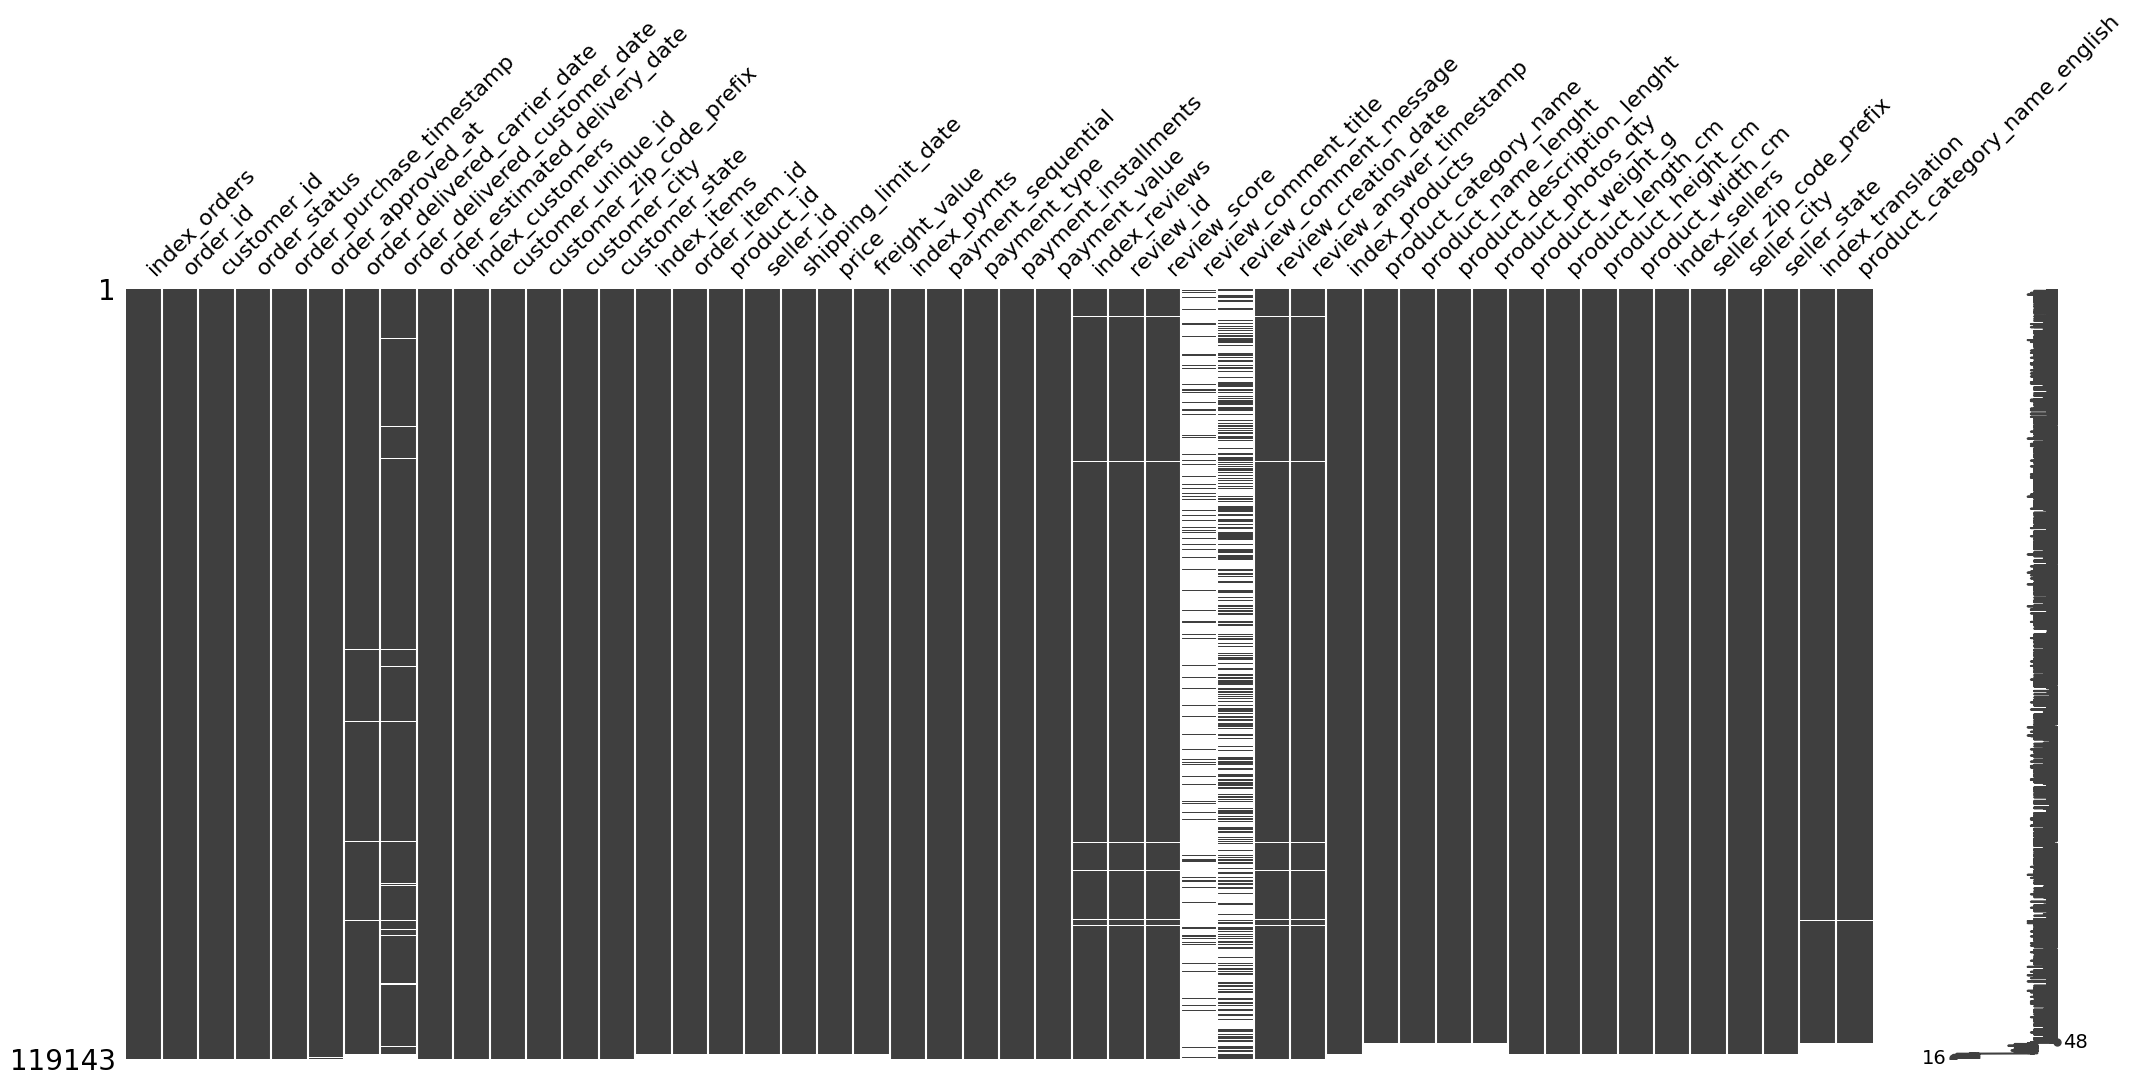

In [83]:
msno.matrix(data)

#### Création de nouvelles variables

In [84]:
# Connexion à la base de données
conn = sqlite3.connect("olist.db")

In [ ]:
# Proportion en % de frais de port dans le total dépensé
"""data["ship_tax"] = data["freight_value"] / data["payment_value"] * 100
data = data.drop(["freight_value"], axis=1)"""

#       Version SQL
query_ship_tax = """
SELECT order_pymts.order_id,
       (order_items.freight_value / order_pymts.payment_value) * 100 AS ship_tax
FROM order_pymts
JOIN order_items ON order_pymts.order_id = order_items.order_id
WHERE order_pymts.payment_value IS NOT NULL
AND order_items.freight_value IS NOT NULL;
"""
ship_tax_df = pd.read_sql_query(query_ship_tax, conn)

In [ ]:
# Panier moyen (montant moyen / cmd)
"""data["purchase_avg"] = data["payment_value"] / data["orders_number"]"""

#       Version SQL
query_purchase_avg = """
SELECT orders.customer_id,
    SUM(order_pymts.payment_value) / COUNT(order_pymts.order_id) AS purchase_avg
FROM order_pymts
JOIN orders ON order_pymts.order_id = orders.order_id
GROUP BY orders.customer_id;
"""
purchase_avg_df = pd.read_sql_query(query_purchase_avg, conn)

In [ ]:
# Fréquence moyenne d'achat
"""data["buying_frequency"] = (data["order_purchase_timestamp"].max() - data["order_purchase_timestamp"]).dt.days / data["orders_number"]"""

#       Version SQL
query_buying_frequency = """
WITH customer_orders AS (
    SELECT customer_id,
        MIN(order_purchase_timestamp) AS first_purchase_date,
        MAX(order_purchase_timestamp) AS last_purchase_date,
        COUNT(order_id) AS orders_number
    FROM orders
    GROUP BY customer_id
)

SELECT customer_id,
    (julianday(last_purchase_date) - julianday(first_purchase_date)) / orders_number AS buying_frequency
FROM customer_orders
WHERE orders_number > 0;
"""
buying_frequency_df = pd.read_sql_query(query_buying_frequency, conn)

In [88]:
# Fermer la connexion
conn.close()

In [89]:
# Jointure des nouvelles variables à "data"
data = data.merge(ship_tax_df, on="order_id", how="left")
data = data.merge(purchase_avg_df, on="customer_id", how="left")
data = data.merge(buying_frequency_df, on="customer_id", how="left")

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195695 entries, 0 to 195694
Data columns (total 51 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_orders                   195695 non-null  int64  
 1   order_id                       195695 non-null  object 
 2   customer_id                    195695 non-null  object 
 3   order_status                   195695 non-null  object 
 4   order_purchase_timestamp       195695 non-null  object 
 5   order_approved_at              195516 non-null  object 
 6   order_delivered_carrier_date   192687 non-null  object 
 7   order_delivered_customer_date  190240 non-null  object 
 8   order_estimated_delivery_date  195695 non-null  object 
 9   index_customers                195695 non-null  int64  
 10  customer_unique_id             195695 non-null  object 
 11  customer_zip_code_prefix       195695 non-null  int64  
 12  customer_city                 

#### Vérifications des lignes

In [91]:
display(data[data.duplicated(keep=False)].head(20))
print("Nombre de lignes dupliquée : ", data[data.duplicated()].shape[0])

,index_orders,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customers,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_items,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index_pymts,payment_sequential,payment_type,payment_installments,payment_value,index_reviews,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index_products,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_sellers,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english,ship_tax,purchase_avg,buying_frequency
12,43838,ca00c2ba5781124bd9493423de6d8862,dafe240fa4132e5da366caf9f6f9caaf,delivered,2018-08-10 18:09:49,2018-08-10 18:25:13,2018-08-13 09:01:00,2018-08-17 19:50:46,2018-08-27 00:00:00,38347,a5e706a547ea42fde80e3cff5316c84b,6950,juquitiba,SP,88923.0,1.0,026f43af35e7951067097527d5c31bcc,269cff2d3c8d205c11f37a52402ea93b,2018-08-14 18:25:13,179.9,31.34,95449.0,1.0,debit_card,1.0,422.48,32722.0,bf6f8b50ce8fa1bca85e3d19c8cf643b,4.0,NaN,NaN,2018-08-18 00:00:00,2018-08-21 00:00:01,26472.0,agro_industria_e_comercio,58.0,1075.0,1.0,10317.0,52.0,33.0,43.0,2130.0,15803.0,catanduva,SP,37.0,agro_industry_and_commerce,7.418103,422.48,0.0
13,43838,ca00c2ba5781124bd9493423de6d8862,dafe240fa4132e5da366caf9f6f9caaf,delivered,2018-08-10 18:09:49,2018-08-10 18:25:13,2018-08-13 09:01:00,2018-08-17 19:50:46,2018-08-27 00:00:00,38347,a5e706a547ea42fde80e3cff5316c84b,6950,juquitiba,SP,88923.0,1.0,026f43af35e7951067097527d5c31bcc,269cff2d3c8d205c11f37a52402ea93b,2018-08-14 18:25:13,179.9,31.34,95449.0,1.0,debit_card,1.0,422.48,32722.0,bf6f8b50ce8fa1bca85e3d19c8cf643b,4.0,NaN,NaN,2018-08-18 00:00:00,2018-08-21 00:00:01,26472.0,agro_industria_e_comercio,58.0,1075.0,1.0,10317.0,52.0,33.0,43.0,2130.0,15803.0,catanduva,SP,37.0,agro_industry_and_commerce,7.418103,422.48,0.0
14,43838,ca00c2ba5781124bd9493423de6d8862,dafe240fa4132e5da366caf9f6f9caaf,delivered,2018-08-10 18:09:49,2018-08-10 18:25:13,2018-08-13 09:01:00,2018-08-17 19:50:46,2018-08-27 00:00:00,38347,a5e706a547ea42fde80e3cff5316c84b,6950,juquitiba,SP,88924.0,2.0,026f43af35e7951067097527d5c31bcc,269cff2d3c8d205c11f37a52402ea93b,2018-08-14 18:25:13,179.9,31.34,95449.0,1.0,debit_card,1.0,422.48,32722.0,bf6f8b50ce8fa1bca85e3d19c8cf643b,4.0,NaN,NaN,2018-08-18 00:00:00,2018-08-21 00:00:01,26472.0,agro_industria_e_comercio,58.0,1075.0,1.0,10317.0,52.0,33.0,43.0,2130.0,15803.0,catanduva,SP,37.0,agro_industry_and_commerce,7.418103,422.48,0.0
15,43838,ca00c2ba5781124bd9493423de6d8862,dafe240fa4132e5da366caf9f6f9caaf,delivered,2018-08-10 18:09:49,2018-08-10 18:25:13,2018-08-13 09:01:00,2018-08-17 19:50:46,2018-08-27 00:00:00,38347,a5e706a547ea42fde80e3cff5316c84b,6950,juquitiba,SP,88924.0,2.0,026f43af35e7951067097527d5c31bcc,269cff2d3c8d205c11f37a52402ea93b,2018-08-14 18:25:13,179.9,31.34,95449.0,1.0,debit_card,1.0,422.48,32722.0,bf6f8b50ce8fa1bca85e3d19c8cf643b,4.0,NaN,NaN,2018-08-18 00:00:00,2018-08-21 00:00:01,26472.0,agro_industria_e_comercio,58.0,1075.0,1.0,10317.0,52.0,33.0,43.0,2130.0,15803.0,catanduva,SP,37.0,agro_industry_and_commerce,7.418103,422.48,0.0
28,71928,010b143d83a59b355cd5a75c0f0fd785,c181ea8a3ec364246642e36dae84bf30,delivered,2017-08-30 23:28:35,2017-08-30 23:44:47,2017-08-31 21:12:48,2017-09-18 15:04:10,2017-10-06 00:00:00,68270,51d121ddc025c1b70f8f62a1b727aecf,76870,ariquemes,RO,437.0,1.0,6ff1fc9209c7854704a4f75c9fac41b4,4e922959ae960d389249c378d1c939f5,2017-09-05 23:44:47,22.0,34.15,18375.0,1.0,credit_card,8.0,224.60,65591.0,64d1910e671c970d0d25718a85f397d5,5.0,NaN,NaN,2017-09-19 00:00:00,2017-09-19 21:09:20,26190.0,agro_industria_e_comercio,59.0,489.0,2.0,233.0,16.0,5.0,13.0,1664.0,12327.0,jacarei,SP,37.0,agro_indust

Nombre de lignes dupliquée :  51985


In [92]:
# Suppression des lignes dupliquée survenu suite aux requette SQL
data.drop_duplicates(inplace=True)

In [93]:
display(data[data.duplicated(keep=False)].head())
print("Nombre de lignes dupliquée : ", data[data.duplicated()].shape[0])

,index_orders,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customers,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_items,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index_pymts,payment_sequential,payment_type,payment_installments,payment_value,index_reviews,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index_products,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_sellers,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english,ship_tax,purchase_avg,buying_frequency


Nombre de lignes dupliquée :  0


In [94]:
# Vérification des commandes marqué comme délivrée
data.loc[data["order_status"] != "delivered"].shape

(4419, 51)

In [95]:
data = data.loc[data["order_status"] == "delivered"]

<Axes: >

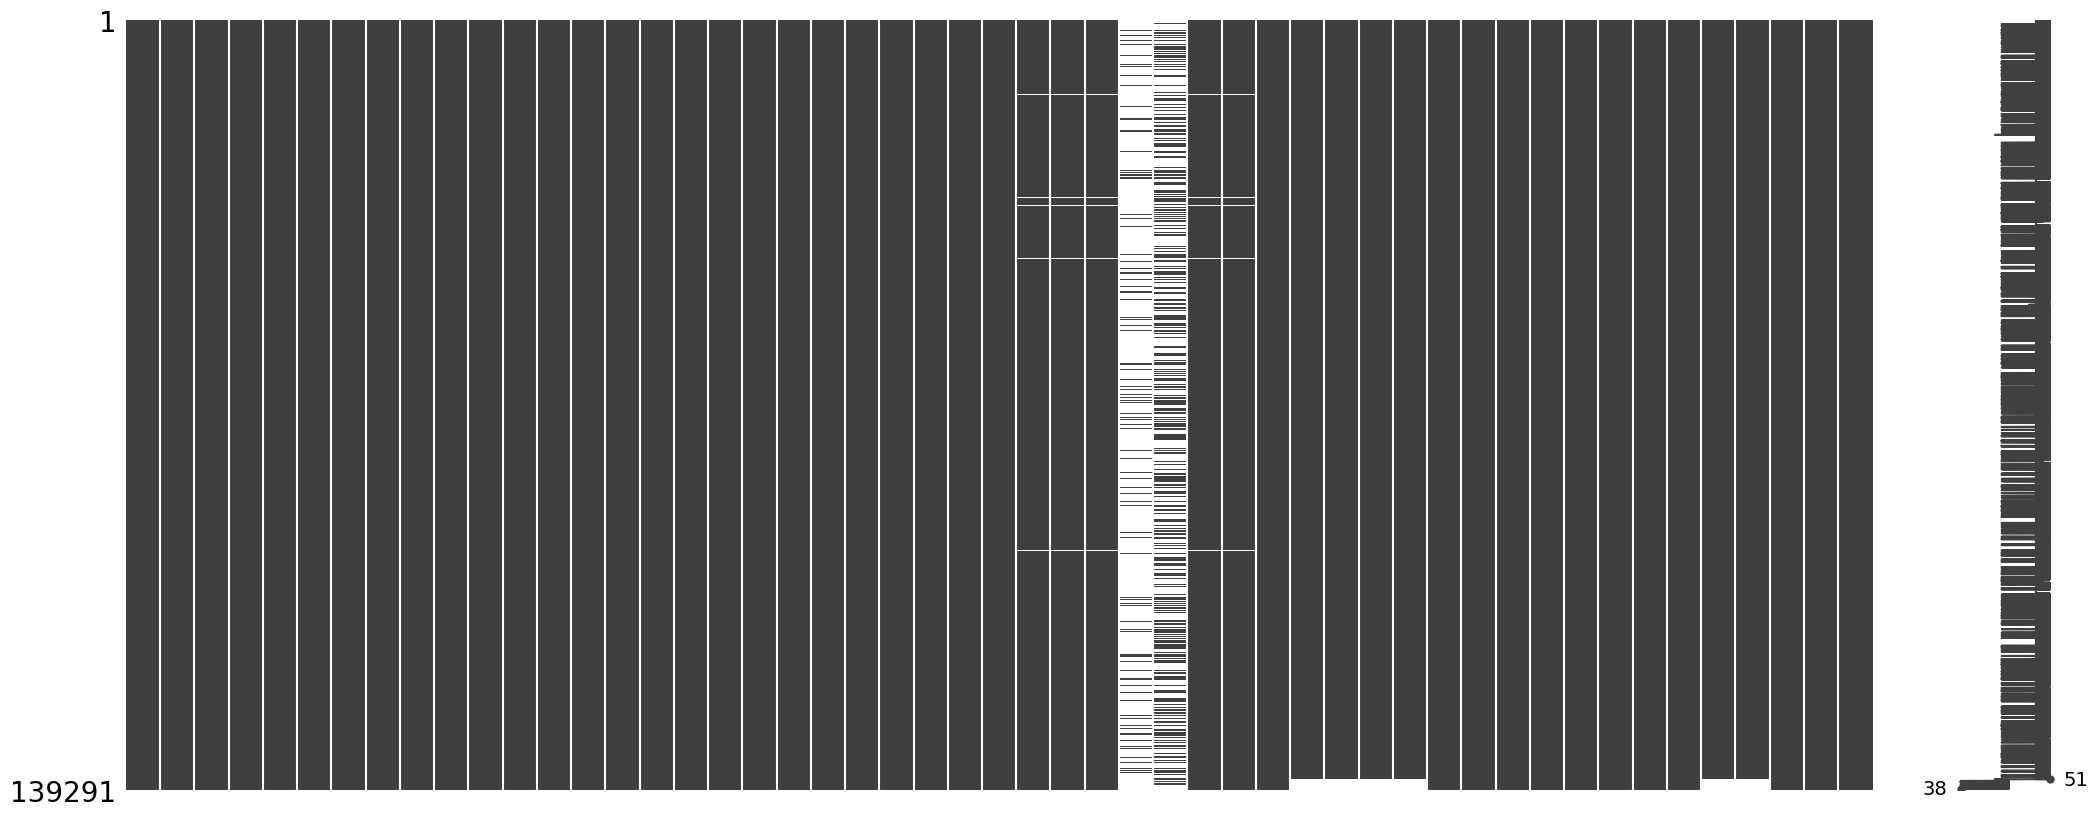

In [96]:
msno.matrix(data)

In [97]:
# Aperçu des valeurs manquantes
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100

missing_data = pd.DataFrame({
    "Valeurs Manquantes": missing_values,
    "Pourcentage (%)": missing_percent
})

missing_data = missing_data[missing_data["Valeurs Manquantes"] >0].sort_values(by="Pourcentage (%)", ascending=False)
print(missing_data)

                               Valeurs Manquantes  Pourcentage (%)
review_comment_title                       123721        88.821963
review_comment_message                      81611        58.590289
index_translation                            1968         1.412869
product_category_name_english                1968         1.412869
product_name_lenght                          1942         1.394204
product_photos_qty                           1942         1.394204
product_description_lenght                   1942         1.394204
product_category_name                        1942         1.394204
index_reviews                                1009         0.724383
review_score                                 1009         0.724383
review_id                                    1009         0.724383
review_creation_date                         1009         0.724383
review_answer_timestamp                      1009         0.724383
product_weight_g                               23         0.01

In [98]:
index_pymts_value = data.loc[data["payment_value"].isna()].index
print(index_pymts_value)

Index([27501, 27502, 27503], dtype='int64')


In [99]:
data = data.loc[~data["payment_value"].isna()]

<Axes: >

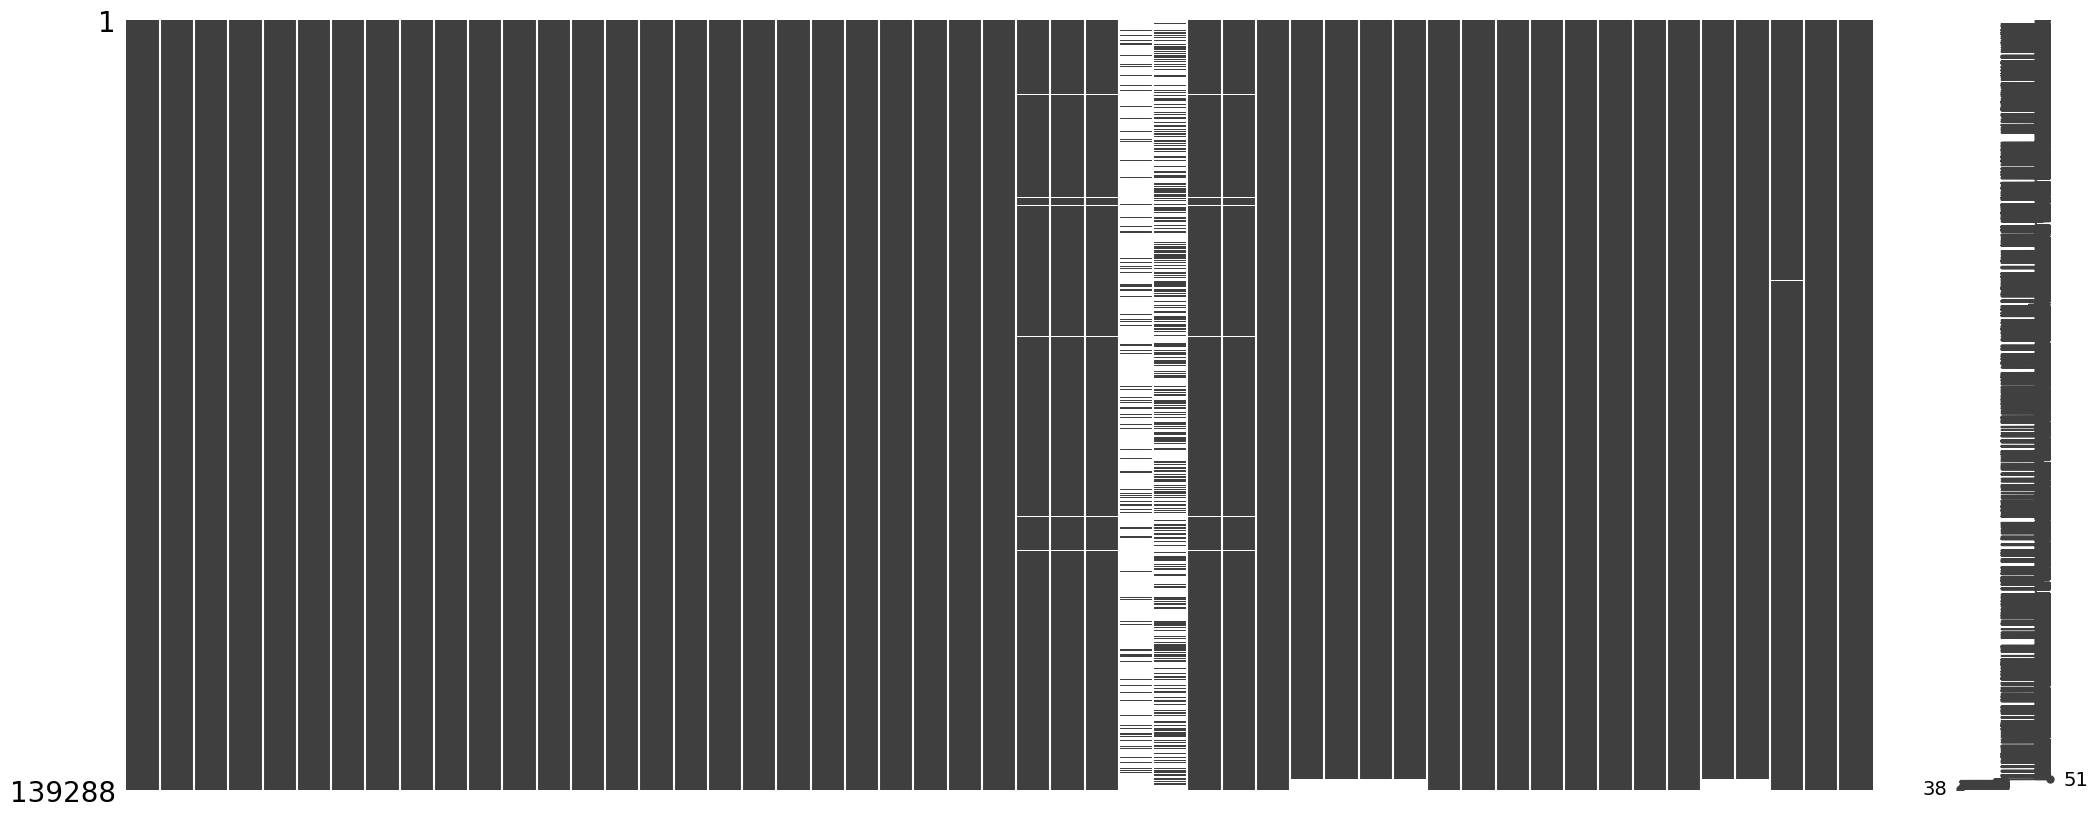

In [100]:
msno.matrix(data)

#### Imputation des valeurs manquantes

In [101]:
# Remplacement des dates de livraison manquante par la date de livraison estimée
data["order_delivered_customer_date"] = data["order_delivered_customer_date"].fillna(data["order_estimated_delivery_date"])

In [102]:
# Remplacement des valeurs manquantes dans "review_score" par la moyenne
data["review_score"] = data["review_score"].fillna(data["review_score"].mean())
data["review_comment_title"] = data["review_comment_title"].fillna("None")
data["review_comment_message"] = data["review_comment_message"].fillna("None")

In [103]:
# Remplacement par 0 des valeurs manquantes liées aux produits
data["product_name_lenght"] = data["product_name_lenght"].fillna(0)
data["product_description_lenght"] = data["product_description_lenght"].fillna(0)
data["product_photos_qty"] = data["product_photos_qty"].fillna(0)
data["product_weight_g"] = data["product_weight_g"].fillna(0)
data["product_length_cm"] = data["product_length_cm"].fillna(0)
data["product_height_cm"] = data["product_height_cm"].fillna(0)
data["product_width_cm"] = data["product_width_cm"].fillna(0)

In [104]:
data["product_category_name_english"].nunique()

71

In [105]:
data["product_category_name"].nunique()

73

In [106]:
data["product_category_name_english"] = data["product_category_name_english"].fillna(data["product_category_name"])

In [107]:
# Apercu des valeurs differente entre les deux catégories de nom de produits
data["product_category_name_english"][~data["product_category_name_english"]
                                    .isin(
                                        translation["product_category_name_english"]
                                        )].value_counts()

product_category_name_english
portateis_cozinha_e_preparadores_de_alimentos    14
pc_gamer                                         12
Name: count, dtype: int64

In [108]:
# Traduction (pt > en) : "portateis_cozinha_e_preparadores_de_alimentos" => "kitchen_portables_and_food_preparers"
data["product_category_name_english"] =\
    data["product_category_name_english"].str\
        .replace("portateis_cozinha_e_preparadores_de_alimentos",
                "kitchen_portables_and_food_preparers")

In [109]:
# Aperçu des valeurs manquantes
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100

missing_data = pd.DataFrame({
    "Valeurs Manquantes": missing_values,
    "Pourcentage (%)": missing_percent
})

missing_data = missing_data[missing_data["Valeurs Manquantes"] >0].sort_values(by="Pourcentage (%)", ascending=False)
print(missing_data)

                               Valeurs Manquantes  Pourcentage (%)
index_translation                            1968         1.412900
product_category_name                        1942         1.394234
product_category_name_english                1942         1.394234
review_creation_date                         1009         0.724398
review_answer_timestamp                      1009         0.724398
index_reviews                                1009         0.724398
review_id                                    1009         0.724398
order_approved_at                              15         0.010769
ship_tax                                       15         0.010769
order_delivered_carrier_date                    2         0.001436


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139288 entries, 0 to 194859
Data columns (total 51 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_orders                   139288 non-null  int64  
 1   order_id                       139288 non-null  object 
 2   customer_id                    139288 non-null  object 
 3   order_status                   139288 non-null  object 
 4   order_purchase_timestamp       139288 non-null  object 
 5   order_approved_at              139273 non-null  object 
 6   order_delivered_carrier_date   139286 non-null  object 
 7   order_delivered_customer_date  139288 non-null  object 
 8   order_estimated_delivery_date  139288 non-null  object 
 9   index_customers                139288 non-null  int64  
 10  customer_unique_id             139288 non-null  object 
 11  customer_zip_code_prefix       139288 non-null  int64  
 12  customer_city                  1392

#### Gestions des dtypes

In [111]:
# Gestion des colonnes au format datetime
col_date = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "shipping_limit_date"]

data[col_date] = data[col_date].apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S")

In [ ]:
# Gestion des colonnes au format catégorie
col_categ = ["order_status", "customer_zip_code_prefix", "customer_city", "customer_state", "payment_type", "seller_zip_code_prefix", "seller_city", "seller_state", "product_category_name_english"]

data[col_categ] = data[col_categ].astype("category")

In [113]:
data.dtypes

index_orders                              int64
order_id                                 object
customer_id                              object
order_status                           category
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
index_customers                           int64
customer_unique_id                       object
customer_zip_code_prefix               category
customer_city                          category
customer_state                         category
index_items                             float64
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           

In [114]:
# Aperçu des dates min/max du dataset
max_date = data["order_purchase_timestamp"].max()
min_date = data["order_purchase_timestamp"].min()

print(f"La date de début commence le {min_date} et elle se termine le {max_date}")

La date de début commence le 2016-10-03 09:44:50 et elle se termine le 2018-08-29 15:00:37


___
Entre le 3 octobre 2016 à 9h44m50s et le 29 août 2018 à 15h00m37s, il s'est écoulé précisément 695 jours.
___

# Création du dataset client

In [115]:
data_clients = df_agg_1(data)
data_clients.to_csv("data_clients.csv")

data_clients2 = df_agg_clients(data)
data_clients2.to_csv("data_clients2.csv")

In [116]:
data_clients.head()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,time_since_first_order,time_since_last_order,mean_shipping_time,mean_delivery_delay,customer_city,customer_state,nb_total_order,nb_total_item,total_price,mean_price,total_freight_value,mean_freight_value,payment_type,mean_payment_installments,total_payment_value,mean_payment_value,mean_review_score,seller_city,seller_state,cat
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-16 20:48:37,2018-05-21,111,111,6,-5,cajamar,SP,1,1,129.90,129.90,12.00,12.00,credit_card,8.0,141.90,141.90,5.0,piracicaba,SP,bed_bath_table
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-10 18:02:42,2018-05-15,114,114,3,-5,osasco,SP,1,1,18.90,18.90,8.29,8.29,credit_card,1.0,27.19,27.19,4.0,sao paulo,SP,health_beauty
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-04-05 14:38:47,2017-04-07,536,536,25,-2,sao jose,SC,1,1,69.00,69.00,17.22,17.22,credit_card,8.0,86.22,86.22,3.0,campo limpo paulista,SP,stationery
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-11-01 21:23:05,2017-11-13,320,320,20,-12,belem,PA,1,1,25.99,25.99,17.63,17.63,credit_card,4.0,43.62,43.62,4.0,sao paulo,SP,telephony
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-27 23:08:56,2017-12-05,287,287,13,-8,sorocaba,SP,1,1,180.00,180.00,16.89,16.89,credit_card,6.0,196.89,196.89,5.0,jacarei,SP,telephony


In [117]:
data_clients.tail()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,time_since_first_order,time_since_last_order,mean_shipping_time,mean_delivery_delay,customer_city,customer_state,nb_total_order,nb_total_item,total_price,mean_price,total_freight_value,mean_freight_value,payment_type,mean_payment_installments,total_payment_value,mean_payment_value,mean_review_score,seller_city,seller_state,cat
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2017-07-06 09:22:00,2017-08-02,446,446,27,-27,sanharo,PE,4,4,3140.00,785.00,994.84,248.71,credit_card,10.0,8269.68,2067.42,5.0,sao paulo,SP,health_beauty
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2018-01-09 22:28:20,2018-01-12,261,261,30,-3,feira de santana,BA,1,1,64.89,64.89,19.69,19.69,credit_card,1.0,84.58,84.58,4.0,laranjal paulista,SP,baby
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2017-02-22 12:45:04,2017-03-24,567,567,14,-30,sinop,MT,1,1,89.90,89.90,22.56,22.56,credit_card,1.0,112.46,112.46,5.0,belo horizonte,MG,auto
ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2018-05-14 11:54:26,2018-05-28,118,118,11,-14,bom jesus do norte,ES,1,1,115.00,115.00,18.69,18.69,credit_card,5.0,133.69,133.69,5.0,ribeirao preto,SP,watches_gifts
ffffd2657e2aad2907e67c3e9daecbeb,2017-05-02 20:18:45,2017-05-10 09:33:48,2017-05-26,483,483,7,-16,campo largo,PR,1,1,56.99,56.99,14.57,14.57,credit_card,4.0,71.56,71.56,5.0,santo andre,SP,perfumery


In [118]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93357 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_purchase_timestamp       93357 non-null  datetime64[ns]
 1   order_delivered_customer_date  93357 non-null  datetime64[ns]
 2   order_estimated_delivery_date  93357 non-null  datetime64[ns]
 3   time_since_first_order         93357 non-null  int64         
 4   time_since_last_order          93357 non-null  int64         
 5   mean_shipping_time             93357 non-null  int64         
 6   mean_delivery_delay            93357 non-null  int64         
 7   customer_city                  93357 non-null  category      
 8   customer_state                 93357 non-null  category      
 9   nb_total_order                 93357 non-null  int64         
 10  nb_total_item                

## Aperçu des colonnes du DataFrame Client

In [119]:
quanti_col = data_clients.select_dtypes(["int64", "float64"]).columns
quali_col = data_clients.select_dtypes(["category", "object", "bool"]).columns
date_col = data_clients.select_dtypes(["datetime64[ns]"]).columns

                           time_since_first_order  time_since_last_order  \
time_since_first_order                   1.000000               0.986778   
time_since_last_order                    0.986778               1.000000   
mean_shipping_time                       0.163479               0.165331   
mean_delivery_delay                     -0.109975              -0.107677   
nb_total_order                           0.047365               0.007508   
nb_total_item                            0.047365               0.007508   
total_price                              0.013271              -0.002553   
mean_price                              -0.007184              -0.008350   
total_freight_value                     -0.013625              -0.034510   
mean_freight_value                      -0.050111              -0.051115   
mean_payment_installments                0.046915               0.041333   
total_payment_value                      0.009014              -0.007650   
mean_payment

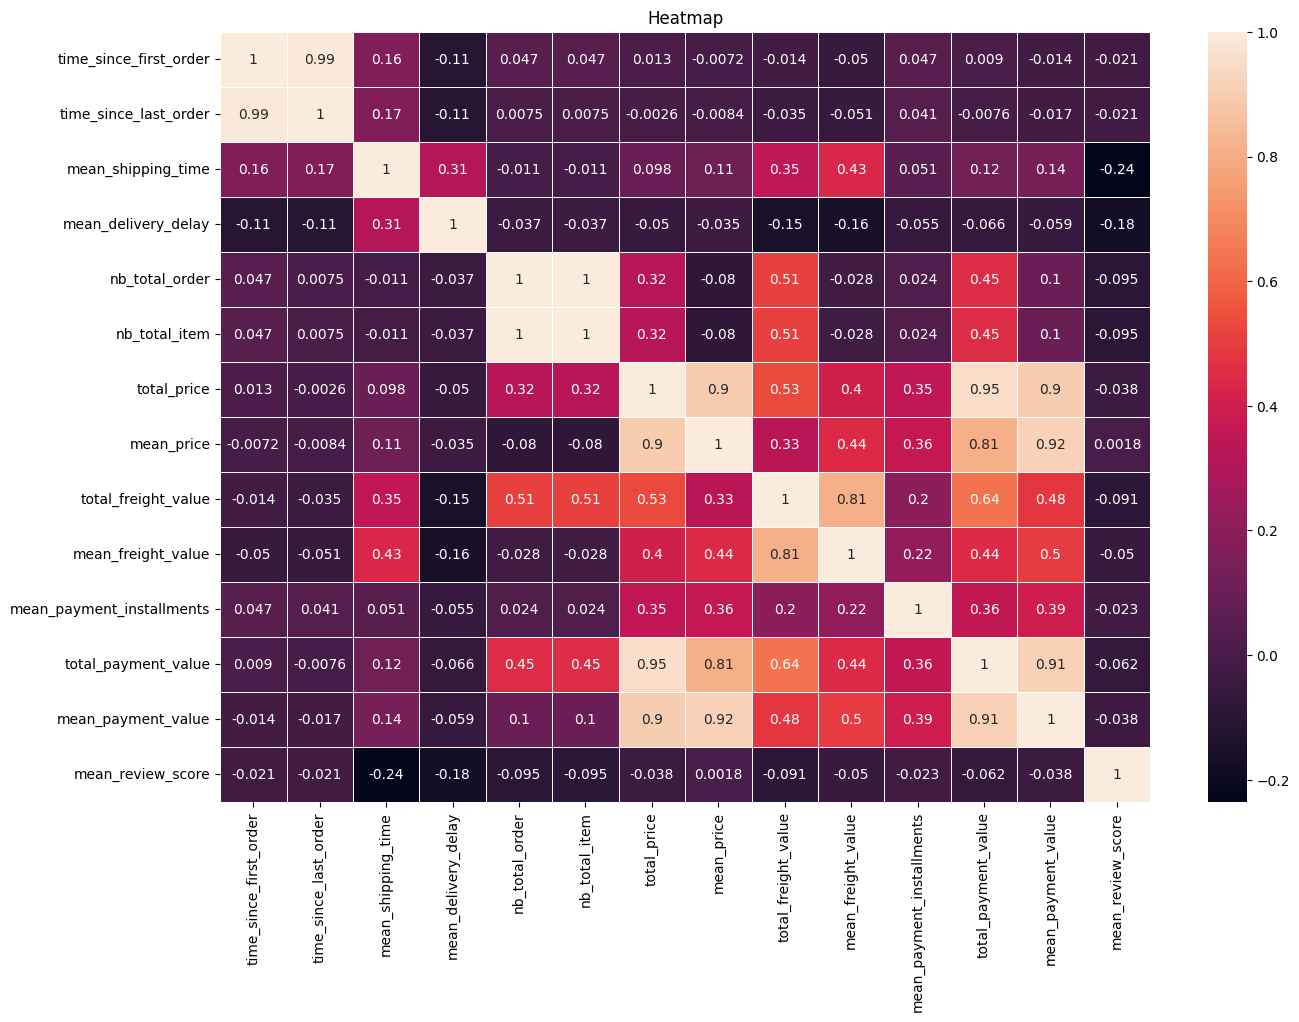

In [120]:
df_corr = data_clients[quanti_col].corr(method="spearman")

plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, linewidth=.5)
plt.title("Heatmap")
print(df_corr)

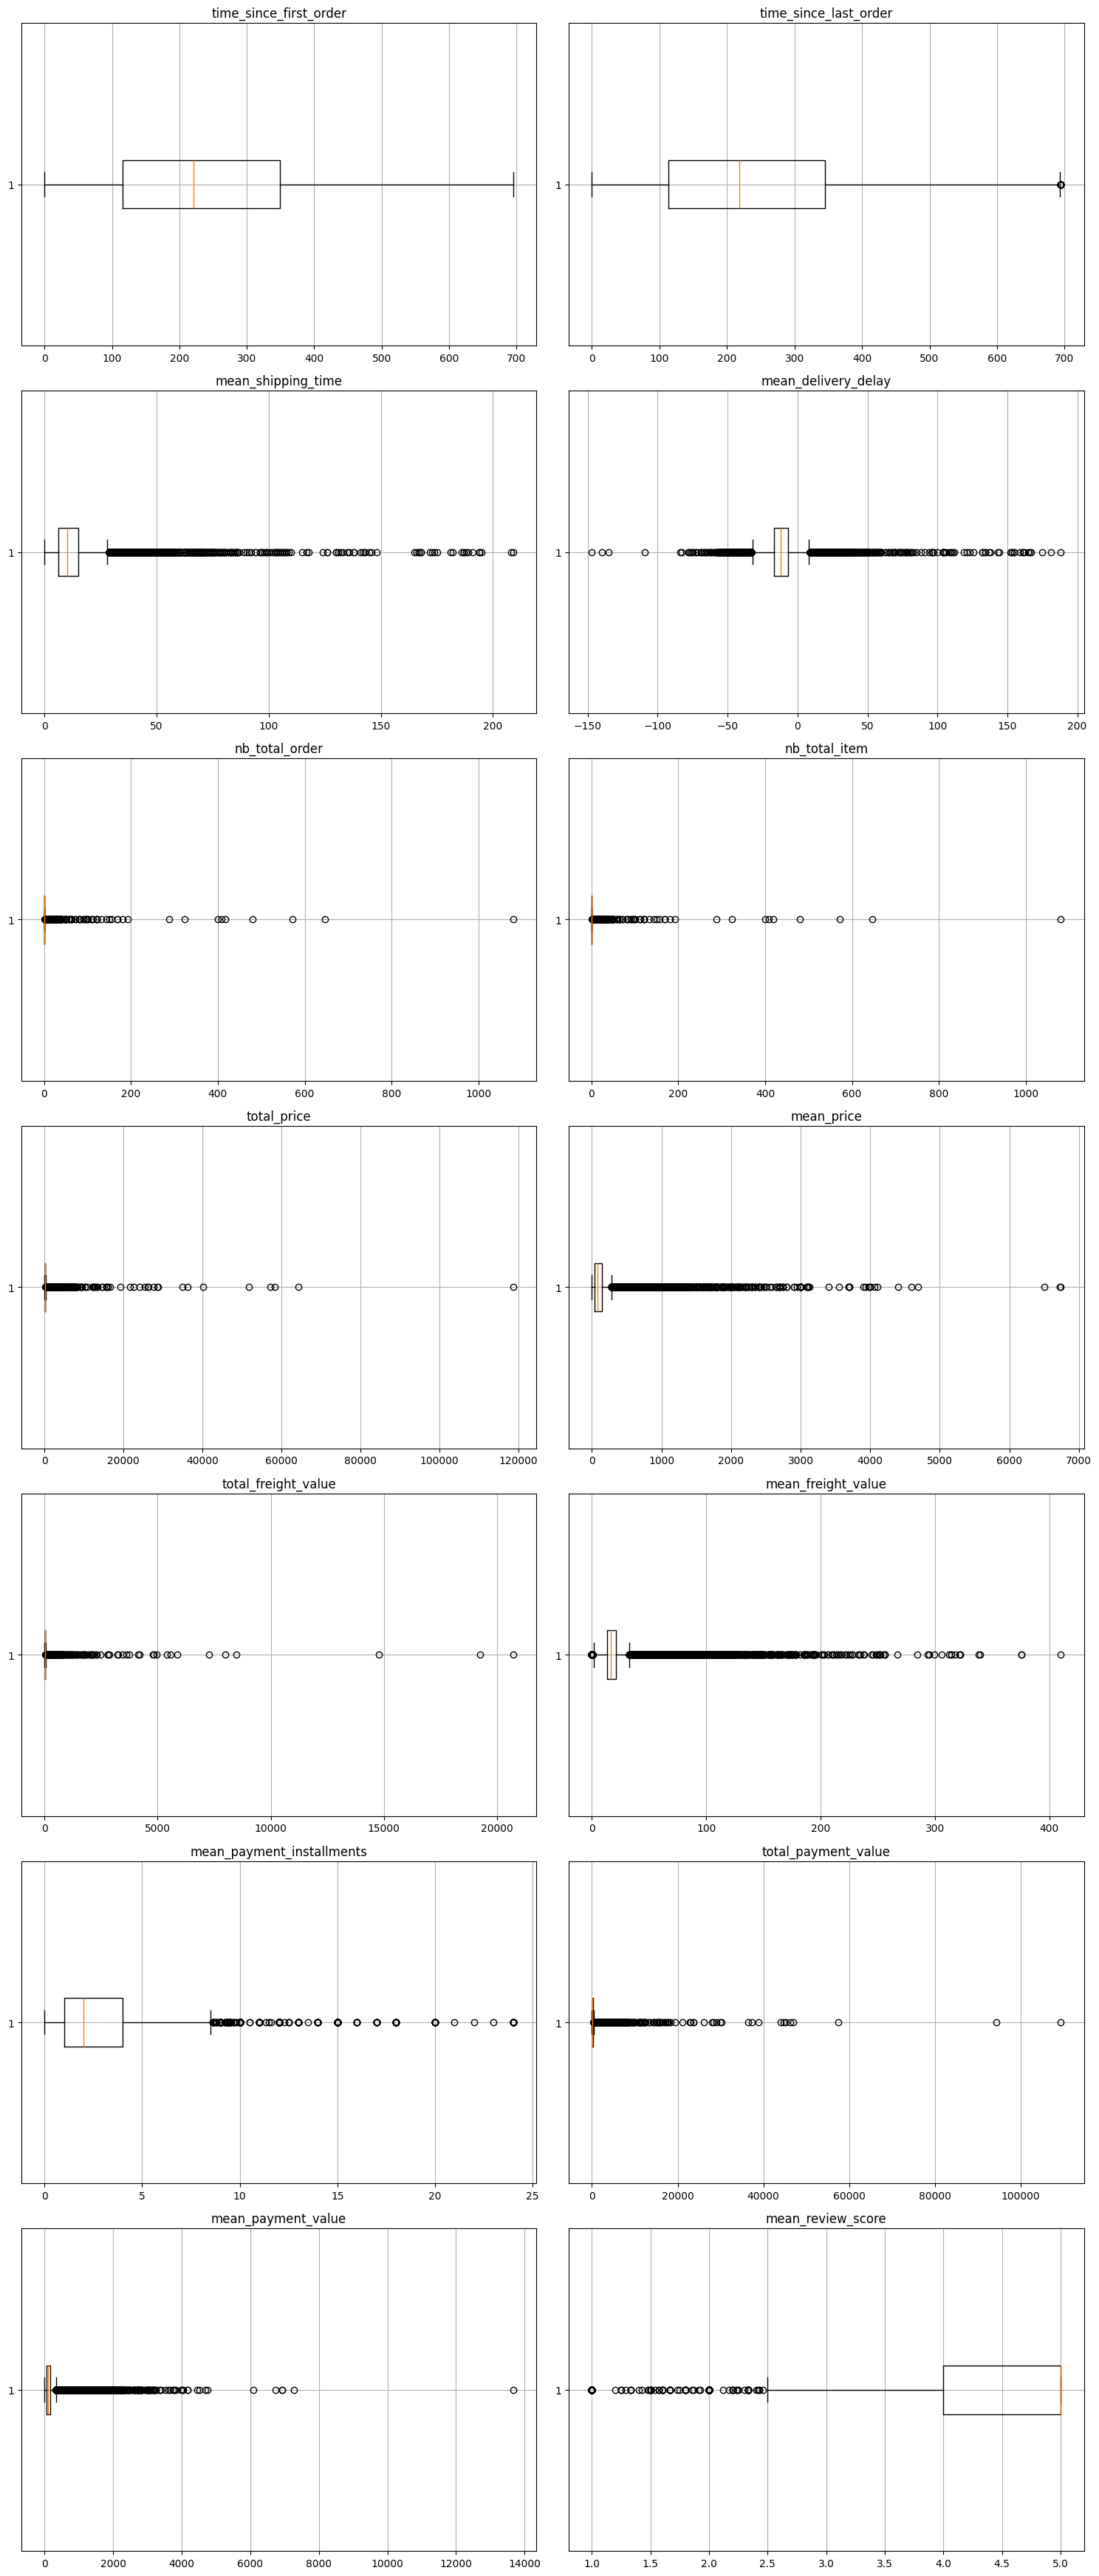

In [121]:
n_cols = 2  # Nombre de boxplots par ligne
n_rows = (len(quanti_col) + 1) // n_cols  # Nombre de lignes nécessaires

# Création des figures
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Parcours des colonnes quantitatives pour créer chaque boxplot
for i, col in enumerate(quanti_col):
    row = i // n_cols
    col_pos = i % n_cols
    ax = axes[row, col_pos]
    ax.boxplot(data_clients[col].dropna(), vert=False)
    ax.set_title(col)
    ax.grid(True)

# Masquer les sous-graphiques vides si le nombre de colonnes est impair
if len(quanti_col) % 2 != 0:
    axes[-1, -1].axis("off")

# Afficher les graphes
plt.tight_layout()
plt.show()

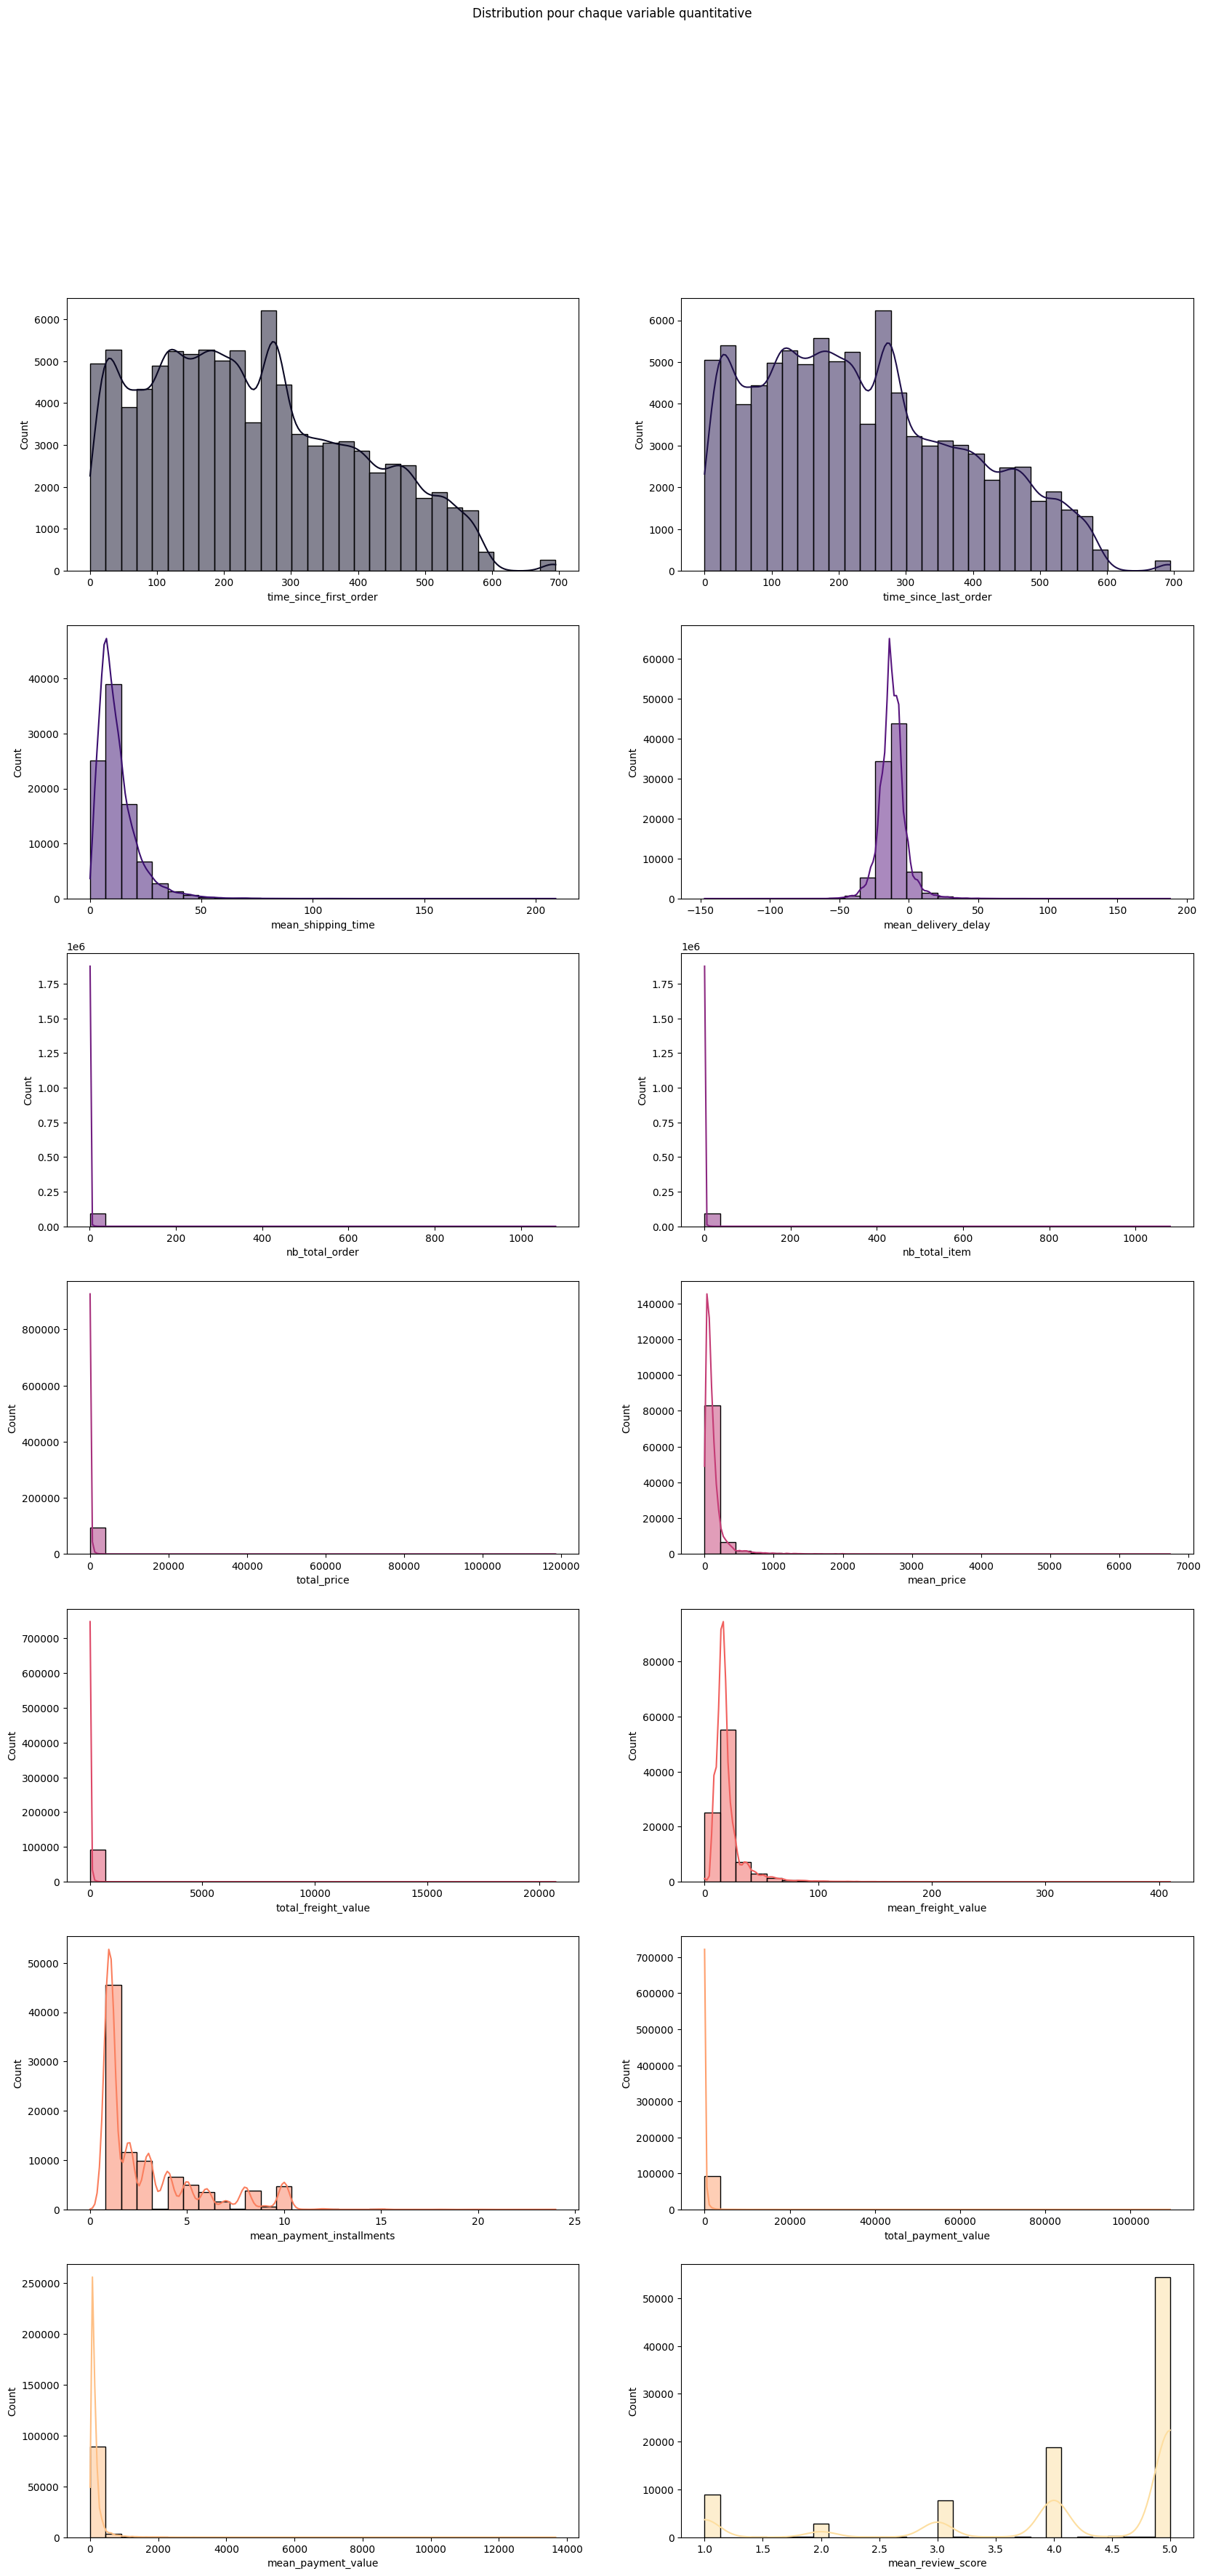

In [122]:
vue_distribution(data_clients, quanti_col, 7, 2)

In [123]:
rapport_normalite(df=data_clients, colonnes=quanti_col)

Tests de normalité sur la variable time_since_first_order.

Test                 Stat            p-value    Résultat
Shapiro Wilk         0.962407        0.000000   H1
Kruskal-Wallis       139888.299685   0.000000   H1
Kolmogorov-Smirnov   0.059652        0.000000   H1

--------------------------------------------------

Tests de normalité sur la variable time_since_last_order.

Test                 Stat            p-value    Résultat
Shapiro Wilk         0.961365        0.000000   H1
Kruskal-Wallis       139880.645012   0.000000   H1
Kolmogorov-Smirnov   0.061046        0.000000   H1

--------------------------------------------------

Tests de normalité sur la variable mean_shipping_time.

Test                 Stat            p-value    Résultat
Shapiro Wilk         0.759114        0.000000   H1
Kruskal-Wallis       138181.652261   0.000000   H1
Kolmogorov-Smirnov   0.149259        0.000000   H1

--------------------------------------------------

Tests de normalité sur la variable m

c:\Users\icema\OpenClassrooms\AI_Engineer\.venv5\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 93357.
  res = hypotest_fun_out(*samples, **kwds)


Kruskal-Wallis       100964.053197   0.000000   H1
Kolmogorov-Smirnov   0.108829        0.000000   H1

--------------------------------------------------

Tests de normalité sur la variable nb_total_order.

Test                 Stat            p-value    Résultat
Shapiro Wilk         0.034981        0.000000   H1
Kruskal-Wallis       80542.808905    0.000000   H1
Kolmogorov-Smirnov   0.468004        0.000000   H1

--------------------------------------------------

Tests de normalité sur la variable nb_total_item.

Test                 Stat            p-value    Résultat
Shapiro Wilk         0.034981        0.000000   H1
Kruskal-Wallis       79952.825393    0.000000   H1
Kolmogorov-Smirnov   0.468004        0.000000   H1

--------------------------------------------------

Tests de normalité sur la variable total_price.

Test                 Stat            p-value    Résultat
Shapiro Wilk         0.096301        0.000000   H1
Kruskal-Wallis       140032.707130   0.000000   H1
Kolmogor

Résultat :
- H0 : (Normalité acceptée) signifie que les données suivent une distribution normale.
- H1 : (normalité rejetée) signifie que les données ne semble pas suivre une distribution normale.

**H** = (Hypothèse)
___
Les differents Tests indiquent que les distribution ne sont pas normales.
___

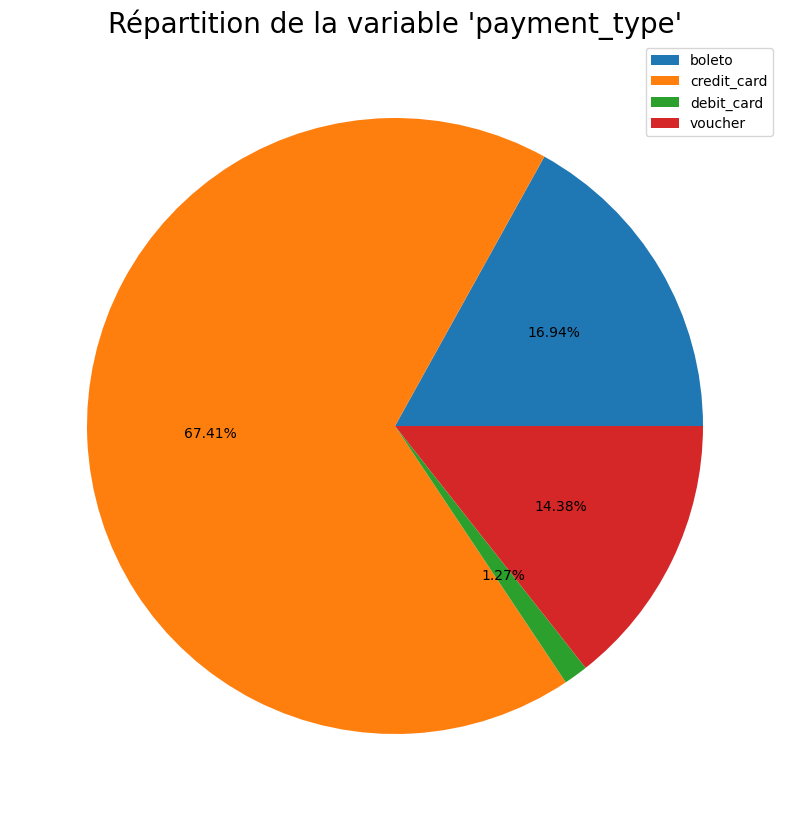

In [124]:
cam_graph(data, ["payment_type"])

___
la majorité des règlements est réalisé par carte de crédit à hauteur de 67.41 %
___

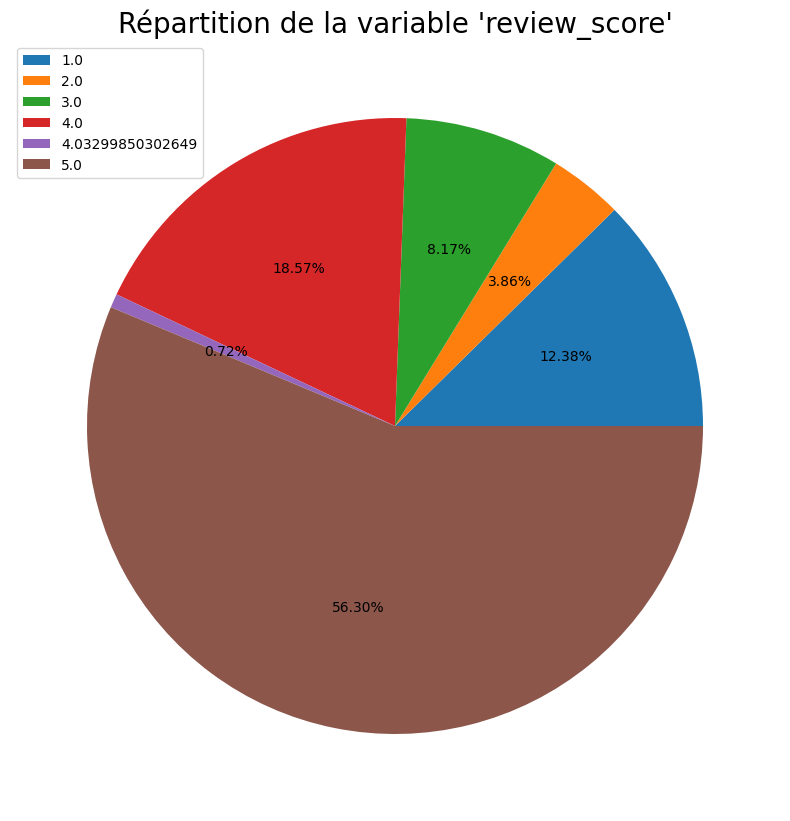

In [125]:
cam_graph(data, ["review_score"])

___
la note majoritaire est de 5 à hauteur de 56.30 %, la note la plus basse 1 représente 12,38 %
___

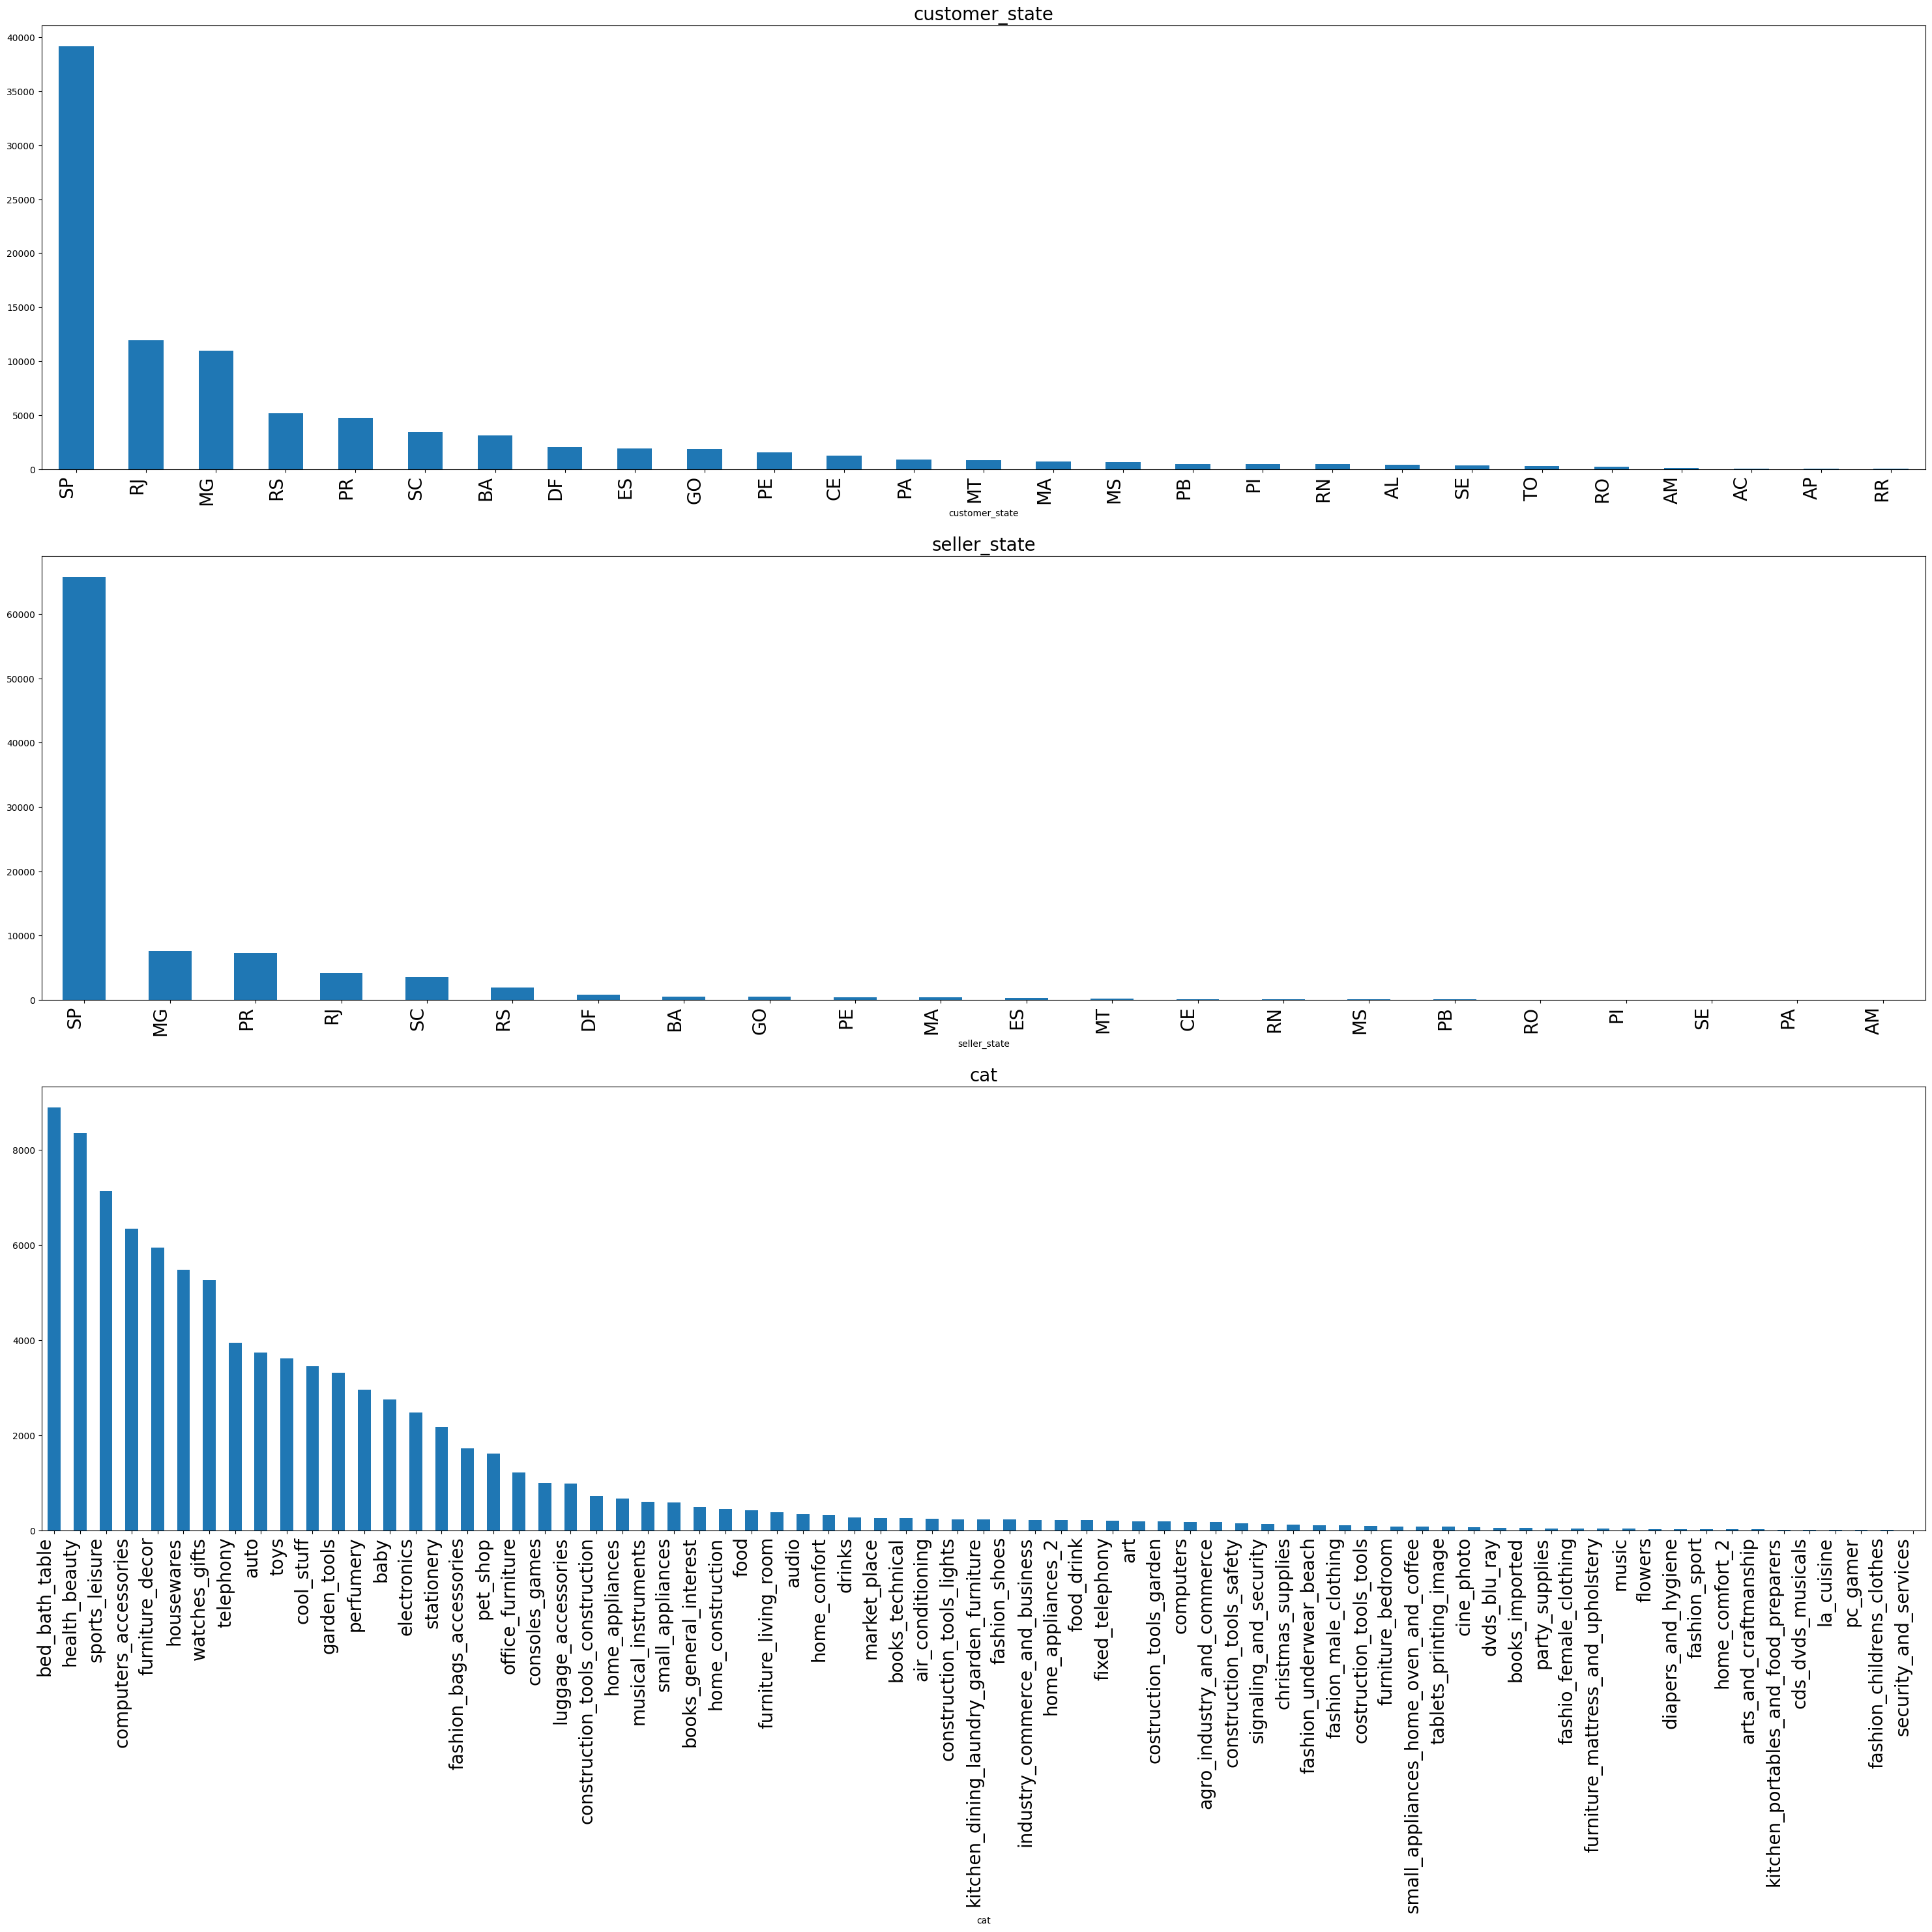

In [126]:
bar_graph(data_clients, ["customer_state", "seller_state", "cat"], 3, 1)

___
- Les clients se trouvent majoritairement dans les états de **São Paulo (SP)** puis **Rio de Janeiro (RJ)** et **Minas Gerais (MG)**
- Les vendeurs se trouvent principalement dans les états de **São Paulo (SP)**, **Minas Gerais (MG)** et **Paraná (PR)**
___
Le dernier graphique nous indique les catégories de produits les plus vendus
- En Top 1, la literie, produit de salle de bains et articles de tables (vaisselles, nappes, couverts...)
- En second les produits de soin personnels, et de santé avec les produits de beauté, comme les cosmétiques, les soins capilaires, la parfumerie...
- Dernier du Top 3, les articles de sport et loisirs
___

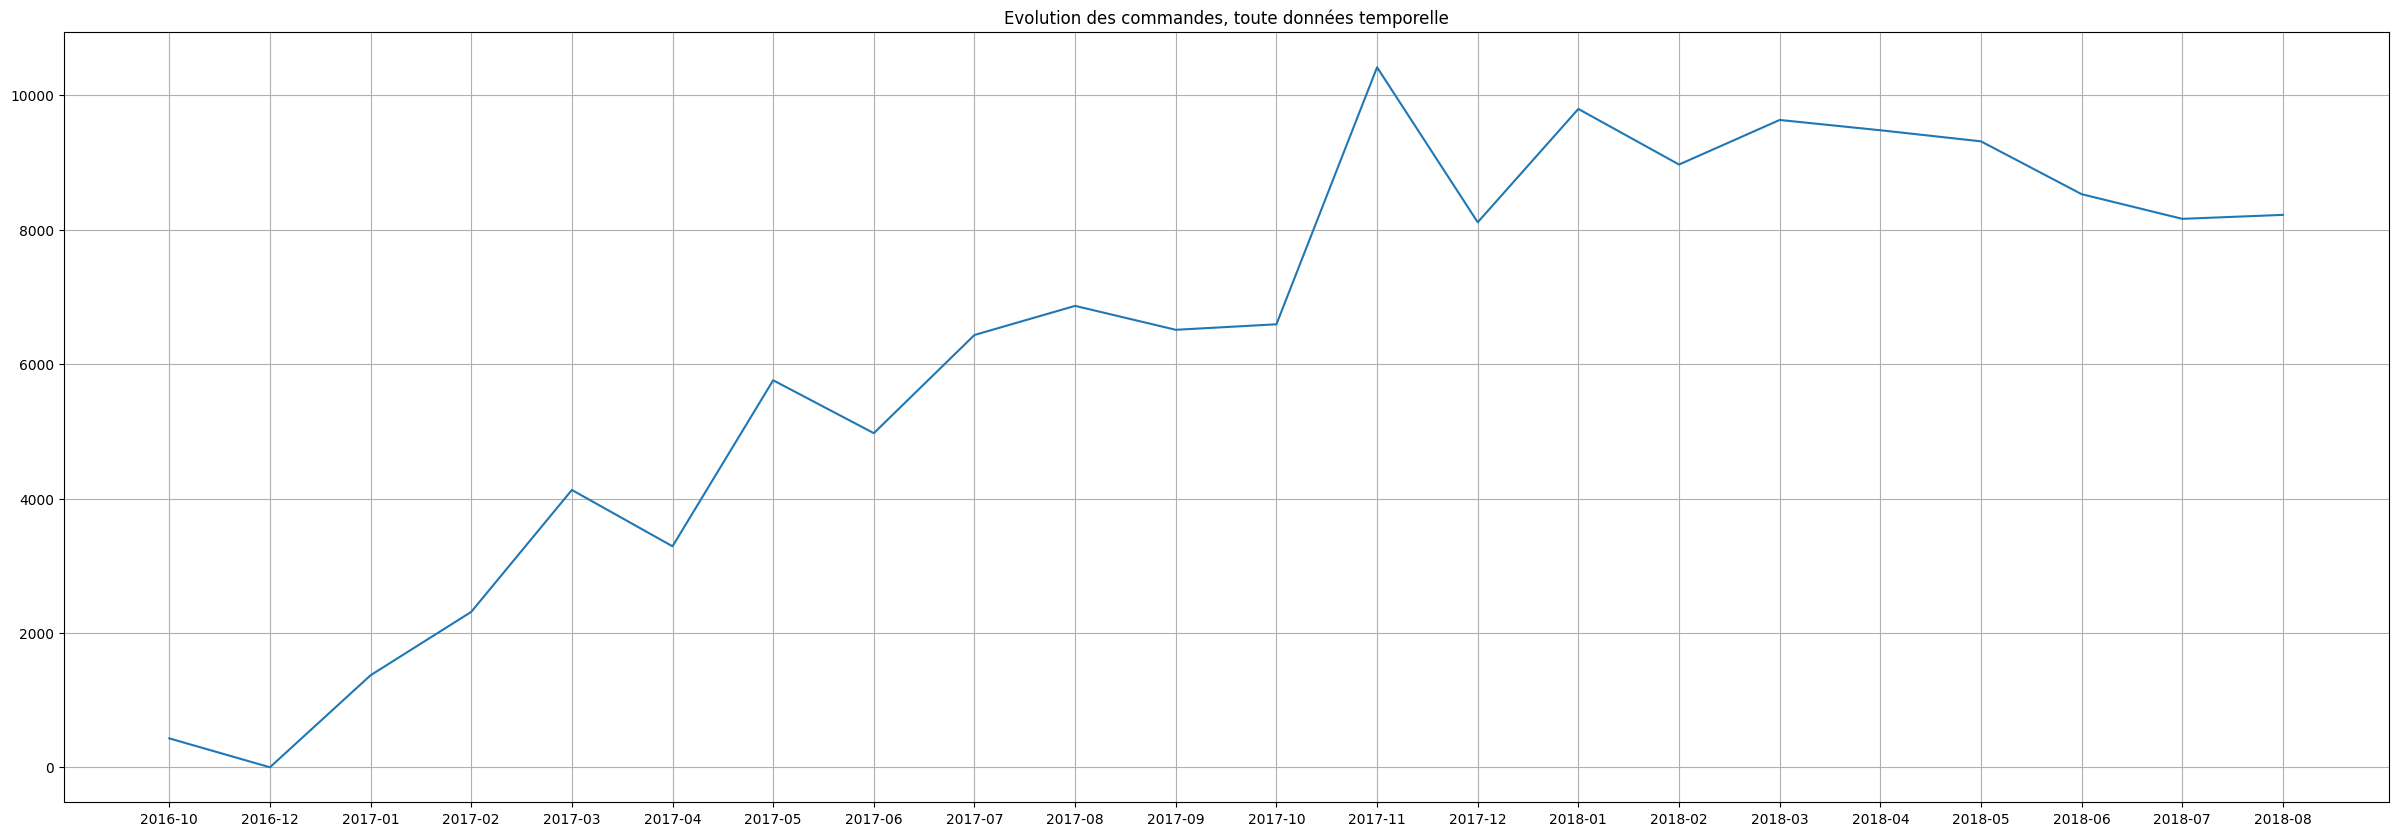

In [127]:
# Evolution des commandes sur les données temporelle disponible
date_order = data.groupby(data["order_purchase_timestamp"].dt.strftime("%Y-%m")) \
    .agg({"order_id" : "count"})

plt.figure(figsize=(30, 10))
plt.plot(date_order)
plt.grid(True)
plt.title("Evolution des commandes, toute données temporelle")
plt.show()

___
- On observe une tendance à la hausse, les commandes augmente au fil du temps.
- Il y a des variations mensuelles marquées, avec des périodes de baisse suivies de reprises, notamment une forte augmentation au début de 2017 qui continue jusqu’à atteindre un pic en novembre 2017.
- Après le pic de fin 2017, on constate une légère baisse des commandes qui se stabilise ensuite.
___

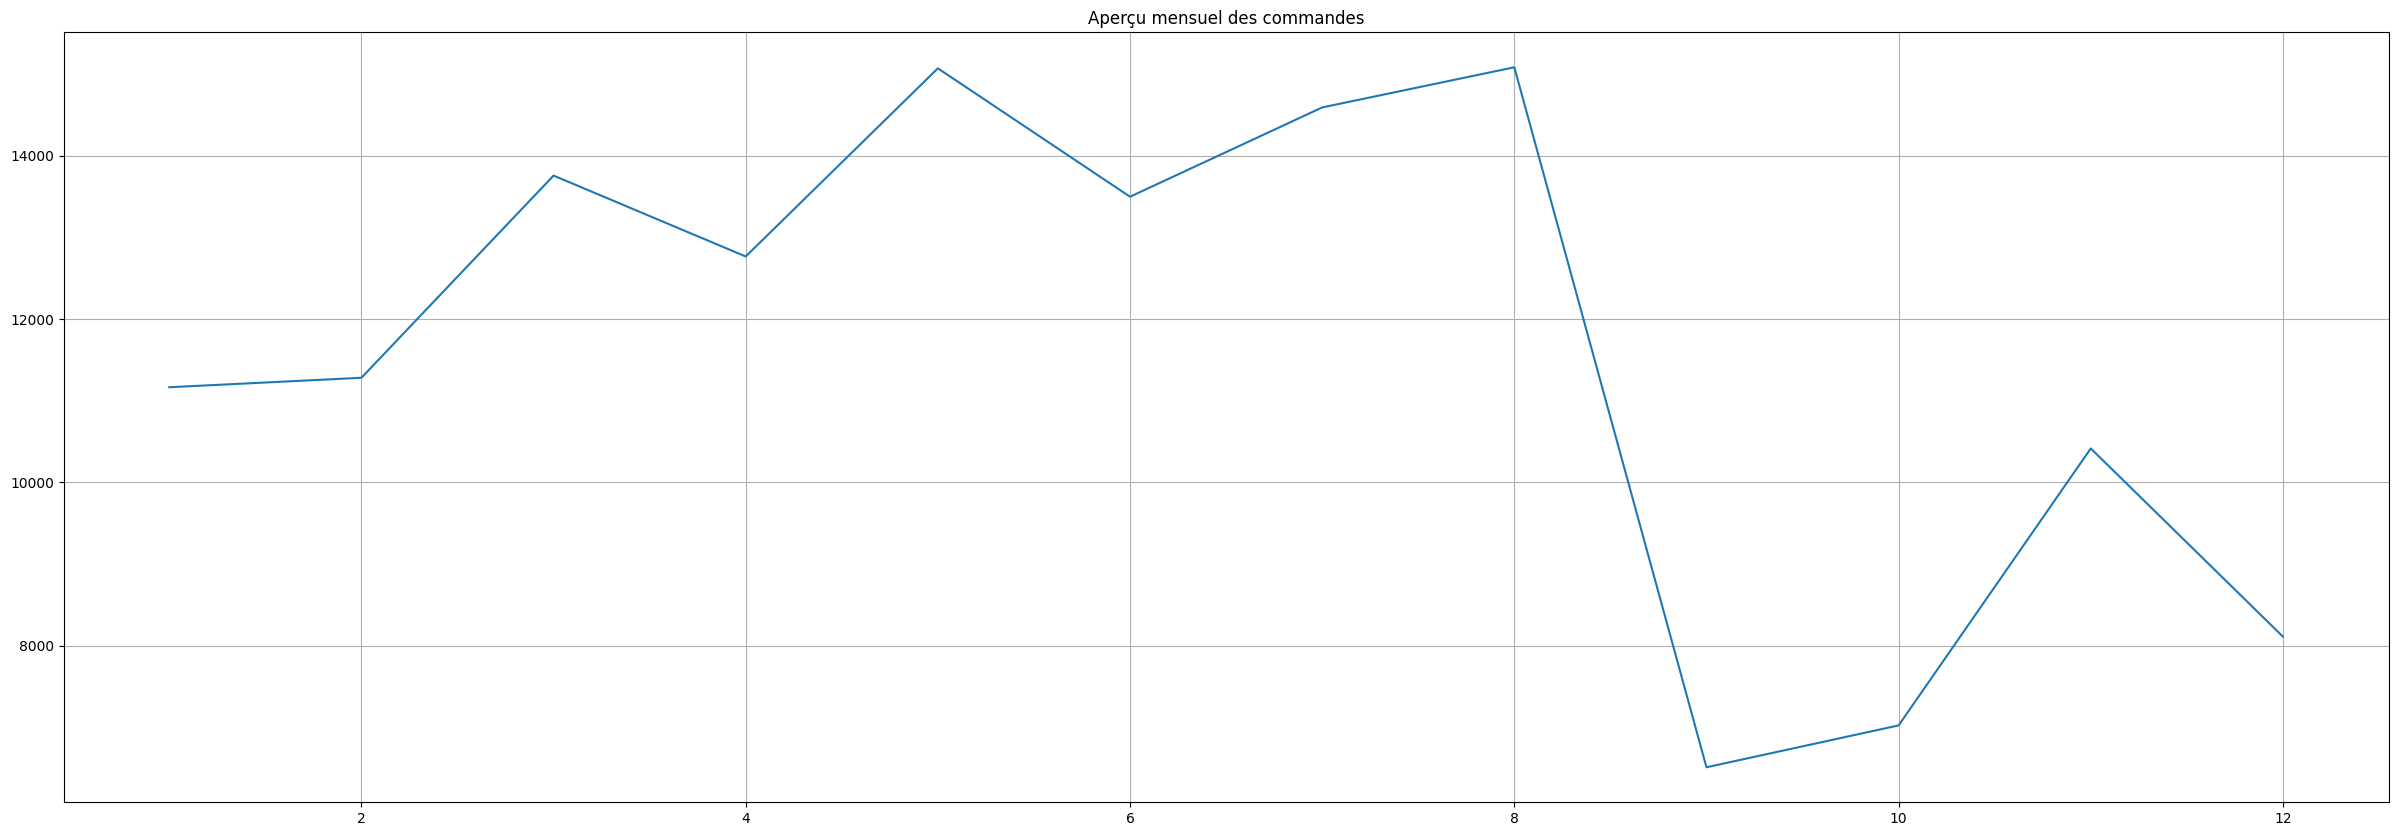

In [128]:
# Evolution des commandes mensuelle
date_order_mois = data.groupby(data["order_purchase_timestamp"].dt.month) \
                                .agg({"order_id" : "count"})

plt.figure(figsize=(30, 10))
plt.plot(date_order_mois)
plt.grid(True)
plt.title("Aperçu mensuel des commandes")
plt.show()

___
- Le nombre de commandes commence relativement stable au début de l'année, puis montre une tendance générale à la hausse jusqu'au mois de juillet.
- Une chute marquée est observée en août. Cela pourrait être lié à une période de vacances ou de moindre activité saisonnière.
- Après le creux d'août, il y a une reprise notable en septembre, qui continue en octobre, puis une légère diminution des commandes en novembre et décembre par rapport à octobre.
___

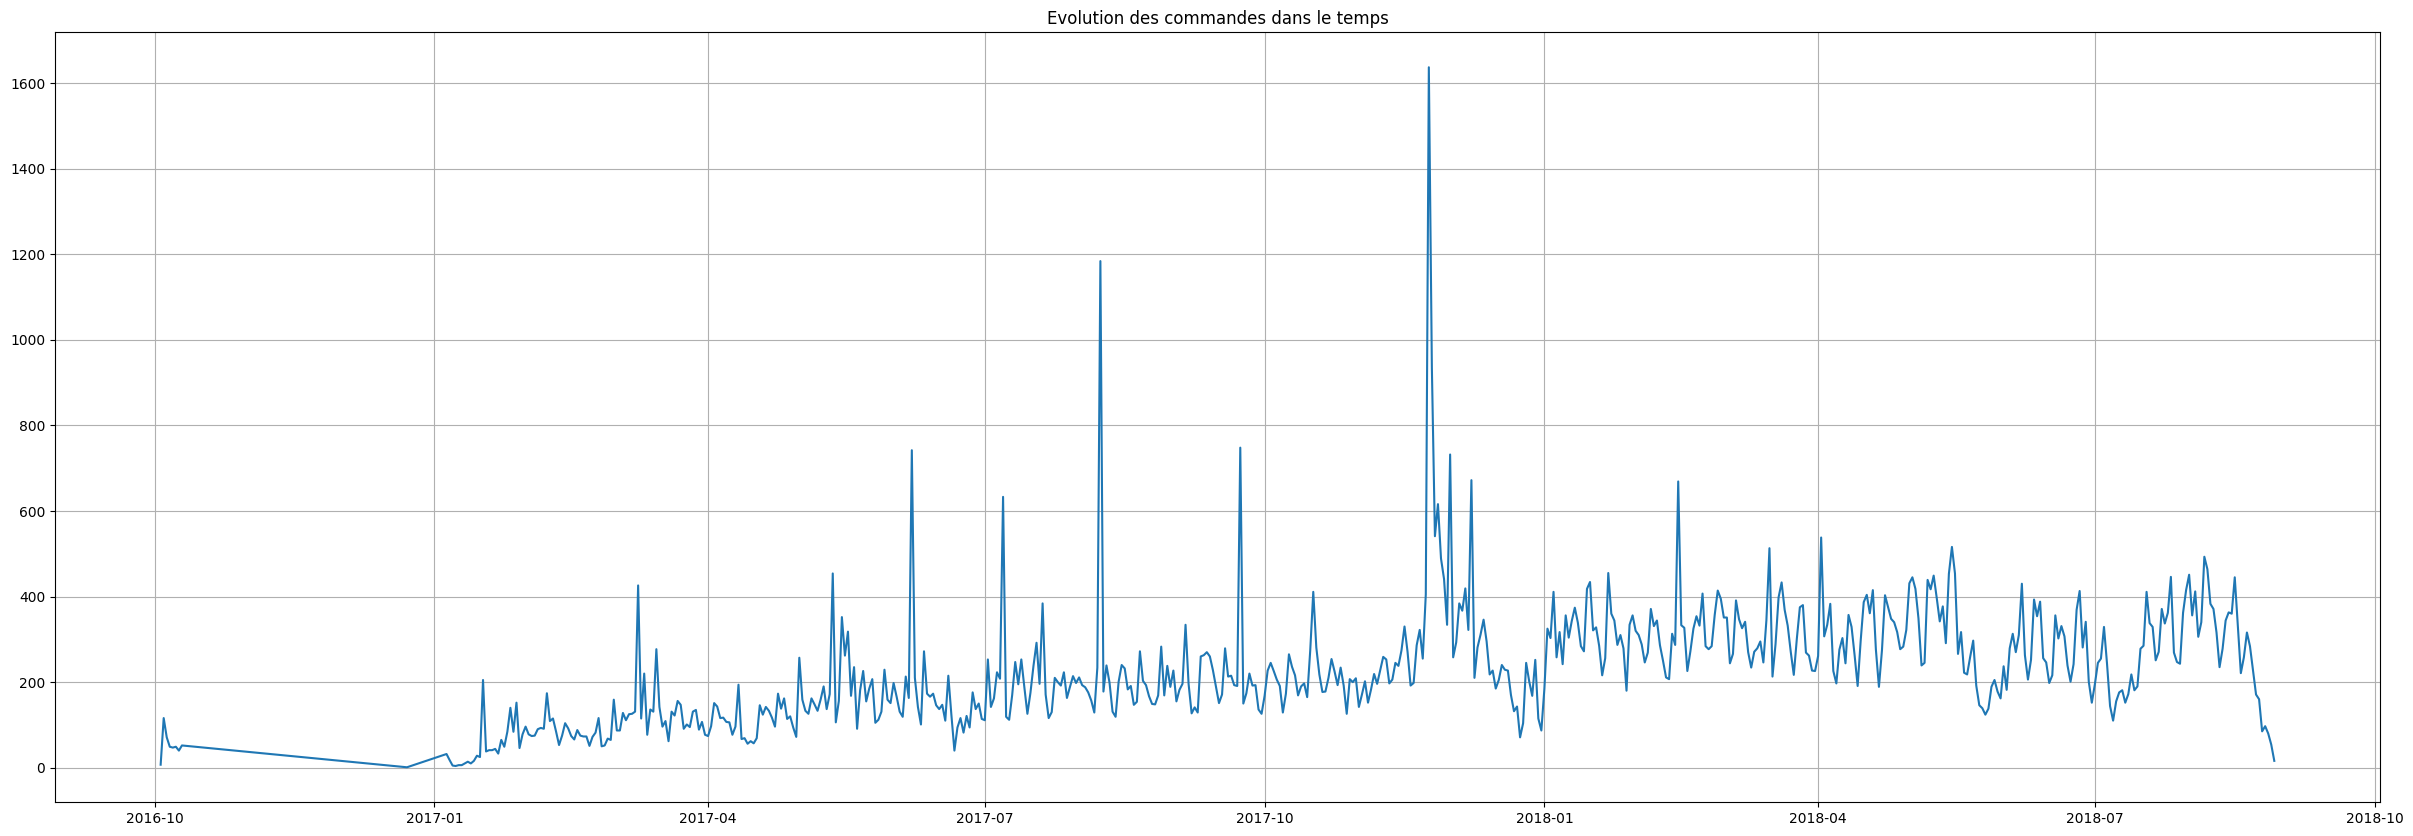

In [ ]:
# Tendance des commandes (vue journalière)
date_order_days = data.groupby(data["order_purchase_timestamp"].dt.date) \
    .agg({"order_id" : "count"})

plt.figure(figsize=(30, 10))
plt.plot(date_order_days)
plt.grid(True)
plt.title("Evolution des commandes dans le temps (vue journalière)")
plt.show()

___
- Au début de la période 2016, le nombre de commandes est faible et relativement stable.
- À partir de 2017, on observe une augmentation de la fréquence des commandes avec des pics marqués dont un pic notable qui apparaît vers la fin de 2017 et qui est bien plus élevé que les autres.
- En 2018, le nombre de commandes semble plus stable, bien que des fluctuations soient toujours présentes. L'activité est plus soutenue qu'au début de la période, avec des cycles réguliers de hauts et de bas.
___

<u>**Conclusions**</u> :    

* Les trois graphiques montrent une augmentation initiale du nombre de commandes, atteignant des pics significatifs, notamment entre 2017 et 2018.
* Dans le deuxième graphique, l'évolution mensuelle du nombre de commandes montre une baisse notable en août, suivie d’une reprise en septembre et octobre. Cela peut être lié à la fin de l’hiver au Brésil.
* Les pics ponctuels, visibles dans le troisième graphique, pourraient également être influencés par des événements commerciaux spécifiques, campagne publicitaire, soldes, etc...

In [130]:
#data_clients.to_csv("data_clients.csv")
#data.to_csv("data1.csv", index = False)
#data_clients.to_csv("data_clients1.csv")